In [1]:
#Loading Libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib.colors import LogNorm


## 1. Importing MiniTimeMatch Dataset

Mount Drive to import data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#setting the path of the jupyter notebook
import os
os.chdir('/content/drive/MyDrive/DL')
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1H5YojvOK5FFRaXCc3eFO529dAYZdHjIN/DL'

Declare path for saving model results

In [4]:
results_path = '/content/drive/MyDrive/DL/Results/'

Unzip data

In [5]:
#!unzip './data_FR1.zip'

In [6]:
# Importing Data
data = np.load("/content/drive/MyDrive/DL/data_FR1.npz", allow_pickle=True)
series = data['series'] # time series (m,l,d) where m is the number of time series in a given domain,
## l is the length of the time series, and d is the number of channels in the image
labels = data['labels'] # label associated with each time series
dates = data['dates'] # acquisition dates (datetime package)
class_names = data['class_names'] # names of the class


## 1.a. Activate CUDA
CUDA Its activated so, when the notebook is ran on colab, it runs on GPU


In [7]:
#Activate CUDA
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Data Exploration

The MiniTimeMatch FR1 dataset presents a timeseries dataset containing information about cropland types in France, extracted for satellite imagery. In the dataset, each observation represents one pixel, with the reflection values for 10 different bands, at 62 different dates. Moreover, the truth crop type for each pixel is provided.

The data is delivered on npz format, storing four different arrays:

`labels` contains the label corresponding to each pixel

In [8]:
lst = data.files
for item in lst:
    print(item)

series
labels
dates
class_names


`series` contains the pixel observations with its reflectance values, for 10 bands and 62 different times.

In [9]:
series.shape

(115755, 62, 10)

`labels` contains the truth label of each pixel, represented as a numerical interger from 0 to 18, corresponding to the 19 possible classes

In [10]:
labels.shape

(115755,)

In [ ]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18], dtype=int32)

`dates` contains the date where each of the 62 timeseries observations where collected.

In [ ]:
dates.shape

(62,)

In [ ]:
print(dates)

[datetime.datetime(2017, 1, 19, 0, 0) datetime.datetime(2017, 1, 29, 0, 0)
 datetime.datetime(2017, 2, 8, 0, 0) datetime.datetime(2017, 2, 18, 0, 0)
 datetime.datetime(2017, 2, 28, 0, 0) datetime.datetime(2017, 3, 10, 0, 0)
 datetime.datetime(2017, 3, 13, 0, 0) datetime.datetime(2017, 3, 30, 0, 0)
 datetime.datetime(2017, 4, 2, 0, 0) datetime.datetime(2017, 4, 9, 0, 0)
 datetime.datetime(2017, 4, 12, 0, 0) datetime.datetime(2017, 4, 19, 0, 0)
 datetime.datetime(2017, 4, 22, 0, 0) datetime.datetime(2017, 4, 29, 0, 0)
 datetime.datetime(2017, 5, 2, 0, 0) datetime.datetime(2017, 5, 9, 0, 0)
 datetime.datetime(2017, 5, 19, 0, 0) datetime.datetime(2017, 5, 22, 0, 0)
 datetime.datetime(2017, 6, 1, 0, 0) datetime.datetime(2017, 6, 8, 0, 0)
 datetime.datetime(2017, 6, 11, 0, 0) datetime.datetime(2017, 6, 18, 0, 0)
 datetime.datetime(2017, 6, 21, 0, 0) datetime.datetime(2017, 6, 28, 0, 0)
 datetime.datetime(2017, 7, 3, 0, 0) datetime.datetime(2017, 7, 6, 0, 0)
 datetime.datetime(2017, 7, 11, 0,

`class_names` contains the real croptype class associated which the labels.

In [ ]:
class_names.shape

(19,)

In [ ]:
print(class_names)

['corn' 'horsebeans' 'meadow' 'spring_barley' 'spring_oat' 'spring_peas'
 'spring_rapeseed' 'spring_rye' 'spring_triticale' 'spring_wheat'
 'sunflowers' 'unknown' 'winter_barley' 'winter_oat' 'winter_peas'
 'winter_rapeseed' 'winter_rye' 'winter_triticale' 'winter_wheat']


### 2.a. Learning task


After analyzing the dataset, it is possible to identify that the task to solve is a multiclass classification problem. Given the reflectance values of a specific pixel for the different bands, at different times of the year, the challenge is to predict the correct croptype for the pixel.

In this sense, it is important to recall that the output layer should be a Sofmax regression, giving the probabilities of samples of belonging to each class. This can be converted to hard-label by considering the class with the maximum probability.

### 2.b. Features Analysis


The data is presented as a 3D array with observations for 115755 different pixels at 62 different days each one, with reflectance values for 10 different bands.

In order to understand the number of explanatory variables, it is necessary to think this 3D dataset as a 2D one, with rows representing observations and columns representing variables, even when this reshaping its not indeed necessary in practice for all the models.

In this sense, as working with time series, we want to predict the coptype class for each pixel based on the 10 bands and 62 records. Hence, in the case of the Multi layer perceptron (MLP), when flattening the data, we would have a total of 620 features (10 bands * 62 timesteps). In the case of CNN, we would still have this number of features but handled with a features (bands) - channels (timesteps) structure.

That said, we can specify that each sample would have a total of 620 quantitative variables corresponding to a subset of the 13 bands provided by Sentinel-2 imagery (B02, B03, B04, B08, B05, B06, B07, B8A, B11, and B12), for 62 timesteps across a year.


### 2.c. Analysis of Explanatory Variables

The first step to easily look at the descriptive statistics of the variables is to transform the shape of the dataset into a 2D array, with the samples in the rows (115755), and the 10 band reflectance values for the 62 time records in the columns. The dates array itself, even when its not directly used as a variable, is analyzed separately for understansing time records distribution.

In [ ]:
#reshape dataset into 2d
series_2d = series.reshape(115755, 10*62)

Once the 2D array is ready, it will be converted into a pandas dataframe to easily look at the descriptive statistics for each explanatory variable using the describe() function

In [ ]:
# Setting Pandas to show every row and columns at visualizations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
#Create list of columns names
cols = ['B02', 'B03', 'B04', 'B08', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12']
# Repeat the column names 61 times and add an index
rep_cols = [f'{col}_{(i-1)//10 + 1}' for i, col in enumerate(cols * 62, start=1)]

#Create dataframe
df = pd.DataFrame(series_2d, columns=rep_cols)

#Setting format to not show values in exponential format
pd.set_option('display.float_format', '{:.2f}'.format)

#Descriptive statistics of the datasets
df.describe()

,B02_1,B03_1,B04_1,B08_1,B05_1,B06_1,B07_1,B8A_1,B11_1,B12_1,B02_2,B03_2,B04_2,B08_2,B05_2,B06_2,B07_2,B8A_2,B11_2,B12_2,B02_3,B03_3,B04_3,B08_3,B05_3,B06_3,B07_3,B8A_3,B11_3,B12_3,B02_4,B03_4,B04_4,B08_4,B05_4,B06_4,B07_4,B8A_4,B11_4,B12_4,B02_5,B03_5,B04_5,B08_5,B05_5,B06_5,B07_5,B8A_5,B11_5,B12_5,B02_6,B03_6,B04_6,B08_6,B05_6,B06_6,B07_6,B8A_6,B11_6,B12_6,B02_7,B03_7,B04_7,B08_7,B05_7,B06_7,B07_7,B8A_7,B11_7,B12_7,B02_8,B03_8,B04_8,B08_8,B05_8,B06_8,B07_8,B8A_8,B11_8,B12_8,B02_9,B03_9,B04_9,B08_9,B05_9,B06_9,B07_9,B8A_9,B11_9,B12_9,B02_10,B03_10,B04_10,B08_10,B05_10,B06_10,B07_10,B8A_10,B11_10,B12_10,B02_11,B03_11,B04_11,B08_11,B05_11,B06_11,B07_11,B8A_11,B11_11,B12_11,B02_12,B03_12,B04_12,B08_12,B05_12,B06_12,B07_12,B8A_12,B11_12,B12_12,B02_13,B03_13,B04_13,B08_13,B05_13,B06_13,B07_13,B8A_13,B11_13,B12_13,B02_14,B03_14,B04_14,B08_14,B05_14,B06_14,B07_14,B8A_14,B11_14,B12_14,B02_15,B03_15,B04_15,B08_15,B05_15,B06_15,B07_15,B8A_15,B11_15,B12_15,B02_16,B03_16,B04_16,B08_16,B05_16,B06_16,B07_16,B8A_16,B11_16,B12_16,B02_17,B03_17,B04_17,B08_17,B05_17,B06_17,B07_17,B8A_17,B11_17,B12_17,B02_18,B03_18,B04_18,B08_18,B05_18,B06_18,B07_18,B8A_18,B11_18,B12_18,B02_19,B03_19,B04_19,B08_19,B05_19,B06_19,B07_19,B8A_19,B11_19,B12_19,B02_20,B03_20,B04_20,B08_20,B05_20,B06_20,B07_20,B8A_20,B11_20,B12_20,B02_21,B03_21,B04_21,B08_21,B05_21,B06_21,B07_21,B8A_21,B11_21,B12_21,B02_22,B03_22,B04_22,B08_22,B05_22,B06_22,B07_22,B8A_22,B11_22,B12_22,B02_23,B03_23,B04_23,B08_23,B05_23,B06_23,B07_23,B8A_23,B11_23,B12_23,B02_24,B03_24,B04_24,B08_24,B05_24,B06_24,B07_24,B8A_24,B11_24,B12_24,B02_25,B03_25,B04_25,B08_25,B05_25,B06_25,B07_25,B8A_25,B11_25,B12_25,B02_26,B03_26,B04_26,B08_26,B05_26,B06_26,B07_26,B8A_26,B11_26,B12_26,B02_27,B03_27,B04_27,B08_27,B05_27,B06_27,B07_27,B8A_27,B11_27,B12_27,B02_28,B03_28,B04_28,B08_28,B05_28,B06_28,B07_28,B8A_28,B11_28,B12_28,B02_29,B03_29,B04_29,B08_29,B05_29,B06_29,B07_29,B8A_29,B11_29,B12_29,B02_30,B03_30,B04_30,B08_30,B05_30,B06_30,B07_30,B8A_30,B11_30,B12_30,B02_31,B03_31,B04_31,B08_31,B05_31,B06_31,B07_31,B8A_31,B11_31,B12_31,B02_32,B03_32,B04_32,B08_32,B05_32,B06_32,B07_32,B8A_32,B11_32,B12_32,B02_33,B03_33,B04_33,B08_33,B05_33,B06_33,B07_33,B8A_33,B11_33,B12_33,B02_34,B03_34,B04_34,B08_34,B05_34,B06_34,B07_34,B8A_34,B11_34,B12_34,B02_35,B03_35,B04_35,B08_35,B05_35,B06_35,B07_35,B8A_35,B11_35,B12_35,B02_36,B03_36,B04_36,B08_36,B05_36,B06_36,B07_36,B8A_36,B11_36,B12_36,B02_37,B03_37,B04_37,B08_37,B05_37,B06_37,B07_37,B8A_37,B11_37,B12_37,B02_38,B03_38,B04_38,B08_38,B05_38,B06_38,B07_38,B8A_38,B11_38,B12_38,B02_39,B03_39,B04_39,B08_39,B05_39,B06_39,B07_39,B8A_39,B11_39,B12_39,B02_40,B03_40,B04_40,B08_40,B05_40,B06_40,B07_40,B8A_40,B11_40,B12_40,B02_41,B03_41,B04_41,B08_41,B05_41,B06_41,B07_41,B8A_41,B11_41,B12_41,B02_42,B03_42,B04_42,B08_42,B05_42,B06_42,B07_42,B8A_42,B11_42,B12_42,B02_43,B03_43,B04_43,B08_43,B05_43,B06_43,B07_43,B8A_43,B11_43,B12_43,B02_44,B03_44,B04_44,B08_44,B05_44,B06_44,B07_44,B8A_44,B11_44,B12_44,B02_45,B03_45,B04_45,B08_45,B05_45,B06_45,B07_45,B8A_45,B11_45,B12_45,B02_46,B03_46,B04_46,B08_46,B05_46,B06_46,B07_46,B8A_46,B11_46,B12_46,B02_47,B03_47,B04_47,B08_47,B05_47,B06_47,B07_47,B8A_47,B11_47,B12_47,B02_48,B03_48,B04_48,B08_48,B05_48,B06_48,B07_48,B8A_48,B11_48,B12_48,B02_49,B03_49,B04_49,B08_49,B05_49,B06_49,B07_49,B8A_49,B11_49,B12_49,B02_50,B03_50,B04_50,B08_50,B05_50,B06_50,B07_50,B8A_50,B11_50,B12_50,B02_51,B03_51,B04_51,B08_51,B05_51,B06_51,B07_51,B8A_51,B11_51,B12_51,B02_52,B03_52,B04_52,B08_52,B05_52,B06_52,B07_52,B8A_52,B11_52,B12_52,B02_53,B03_53,B04_53,B08_53,B05_53,B06_53,B07_53,B8A_53,B11_53,B12_53,B02_54,B03_54,B04_54,B08_54,B05_54,B06_54,B07_54,B8A_54,B11_54,B12_54,B02_55,B03_55,B04_55,B08_55,B05_55,B06_55,B07_55,B8A_55,B11_55,B12_55,B02_56,B03_56,B04_56,B08_56,B05_56,B06_56,B07_56,B8A_56,B11_56,B12_56,B02_57,B03_57,B04_57,B08_57,B05_57,B06_57,B07_57,B8A_57,B11_57,B12_57,B02_58,B03_58,B04_58,B08_58,B05_58,B06_58,B07_58,B8A_58,B11_58,B12_58,B02_59,B03_59,B04_59,B08_59,B

The descriptive statistics show that, even when all the variables represent reflectance value, their scales differ significatively. This variation occurs also between the same band comparing different timestep records.

Given the high dimensionality, it is really hard to read the descriptive variables for the 620 features, and also to graphically visualize the distribution of values for the 10 bands at the 62 time steps. Hence, some summary visualizations are presented to better understand the variables' distributions across time.

First, a boxplot of the values distribution of all bands across time is presented below.

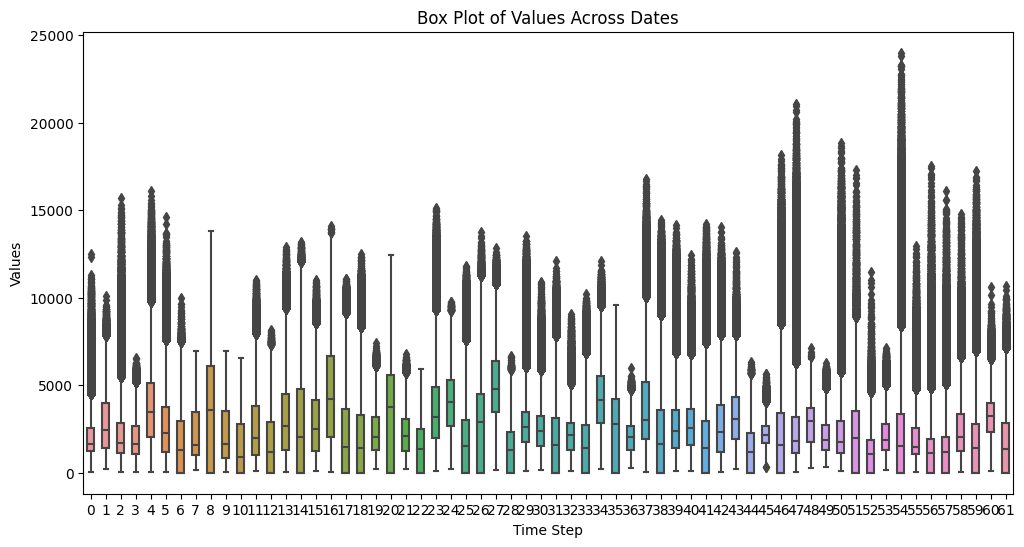

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=np.moveaxis(series, 1, -1).reshape(-1, series.shape[1]), width=0.5)
plt.title('Box Plot of Values Across Dates')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.show()

This graph allows understanding that the values of the bands varys across the year. We can not observe the individual bands' variations but we do observe general change patterns that are probably related with the seasonal changes in crops.

Moreover, a second approach is to look at each bands' values distribution. For a first exploration, the graphics below show the total distribution of values for each band (considering all time steps).

<Figure size 1200x800 with 0 Axes>

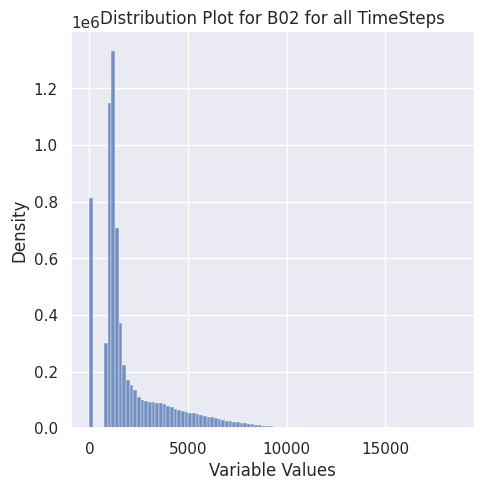

<Figure size 1200x800 with 0 Axes>

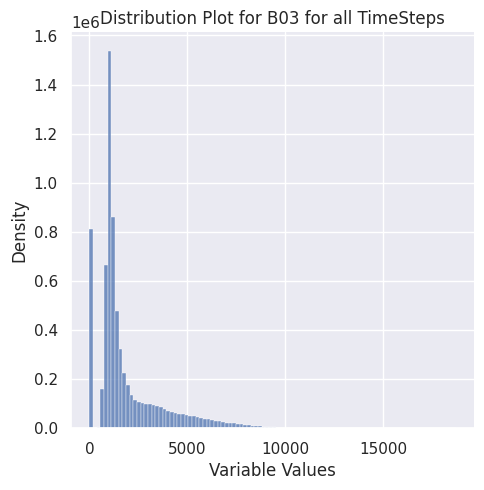

<Figure size 1200x800 with 0 Axes>

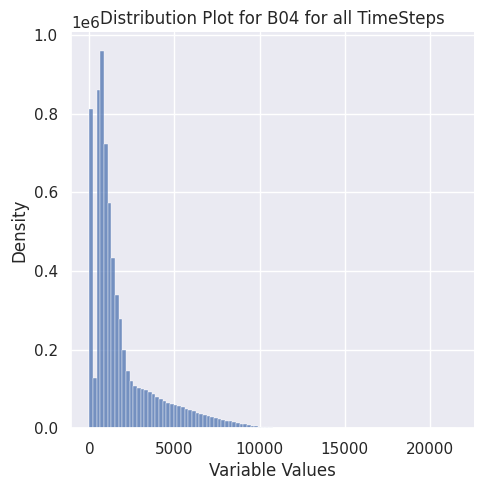

<Figure size 1200x800 with 0 Axes>

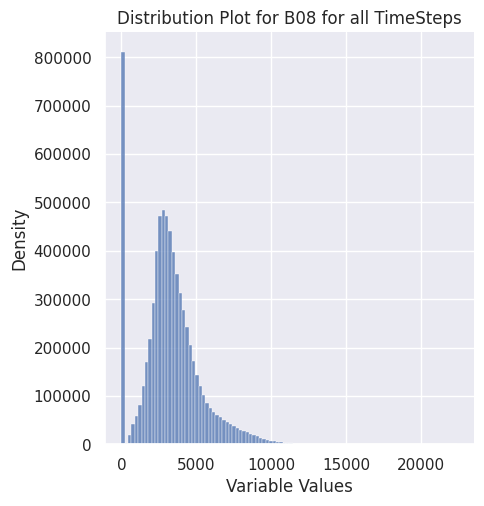

<Figure size 1200x800 with 0 Axes>

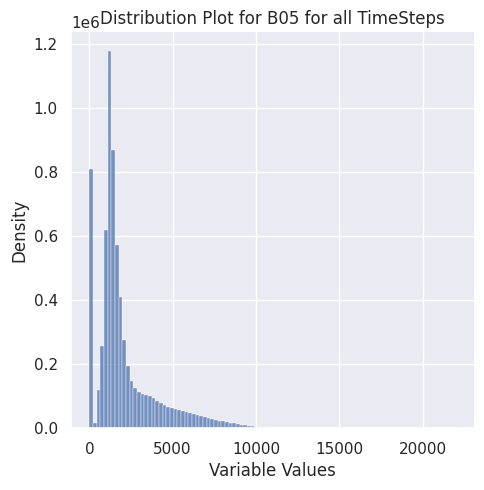

<Figure size 1200x800 with 0 Axes>

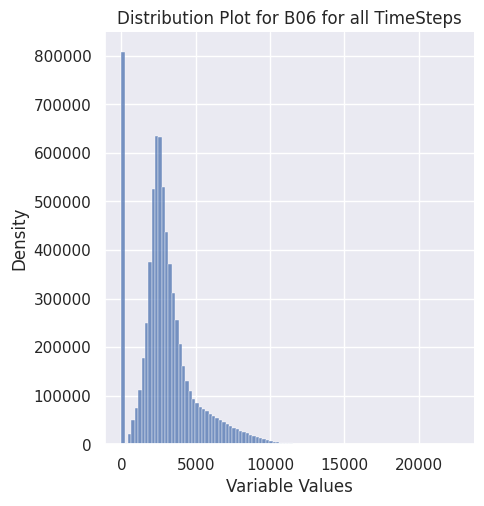

<Figure size 1200x800 with 0 Axes>

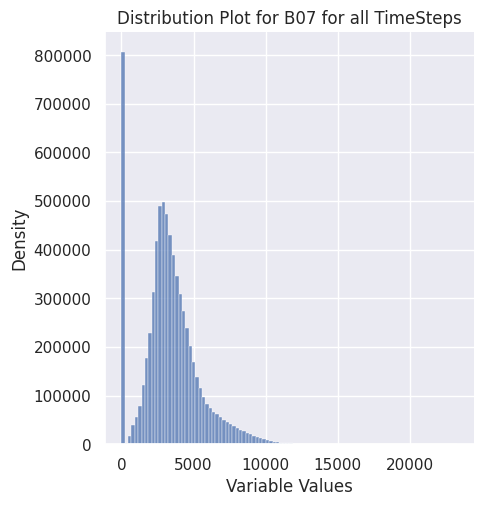

<Figure size 1200x800 with 0 Axes>

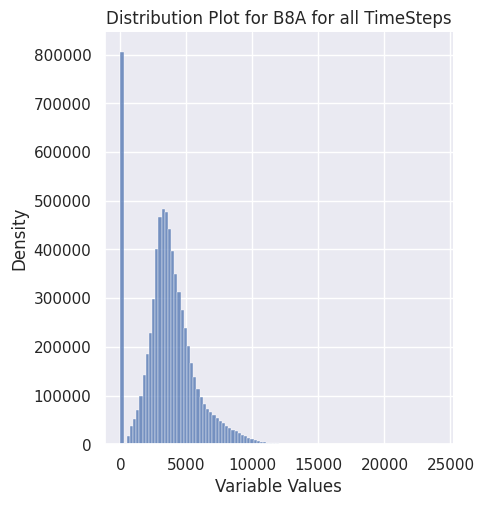

<Figure size 1200x800 with 0 Axes>

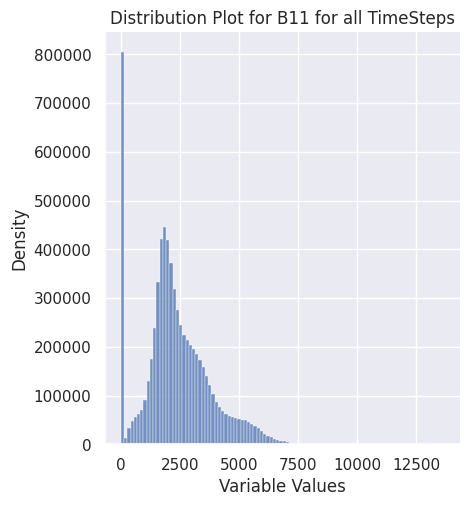

<Figure size 1200x800 with 0 Axes>

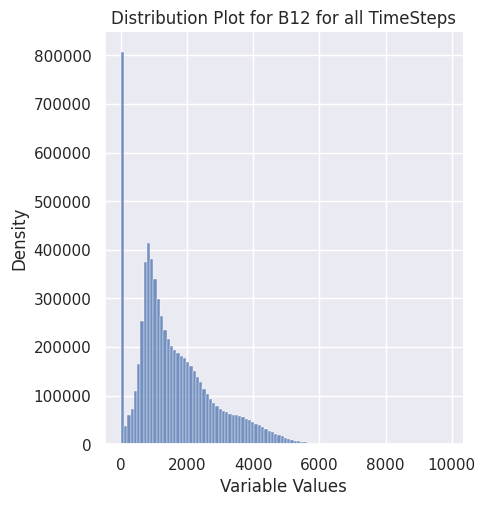

In [ ]:
#Reshape dataset to get each time step records as a new set of samples
data_2d_b = series.reshape(115755*62, 10)
data_2d_b_df = pd.DataFrame(data_2d_b, columns=cols)

sns.set_theme()

warnings.filterwarnings("ignore", category=FutureWarning)

# Plot distribution plots for each variable in separate subplots
for i, column in enumerate(data_2d_b_df.columns):
    plt.figure(figsize=(12, 8))
    sns.displot(data_2d_b_df[column], bins=100)
    plt.title(f'Distribution Plot for {column} for all TimeSteps')
    plt.xlabel('Variable Values')
    plt.ylabel('Density')


 The distribution graphics show that all bands are left skewed. However this could be an effect of grouping all the timesteps. In order to have a clearer idea of what is happening at each timestep, the graphs below show the same analysis, band per band, but for the first timestep as one exemplification case.

<Figure size 1200x800 with 0 Axes>

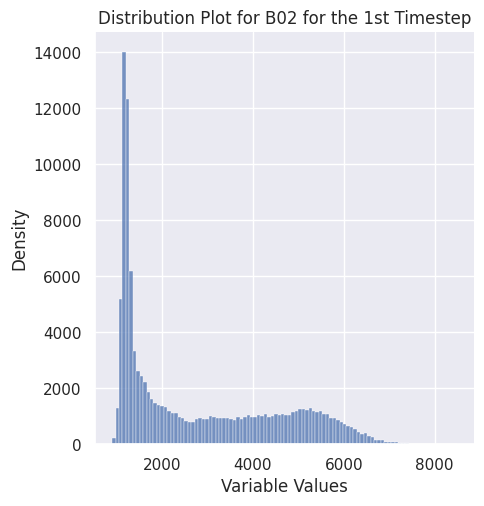

<Figure size 1200x800 with 0 Axes>

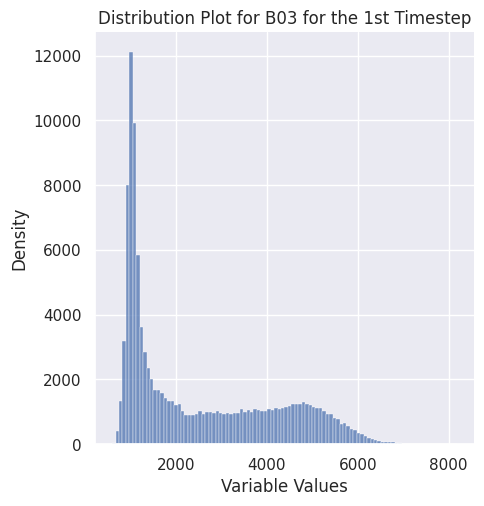

<Figure size 1200x800 with 0 Axes>

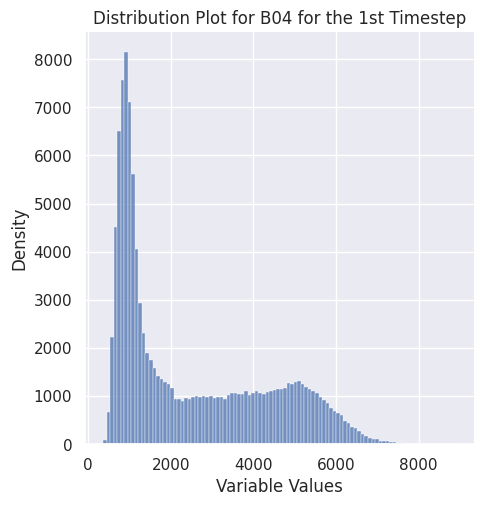

<Figure size 1200x800 with 0 Axes>

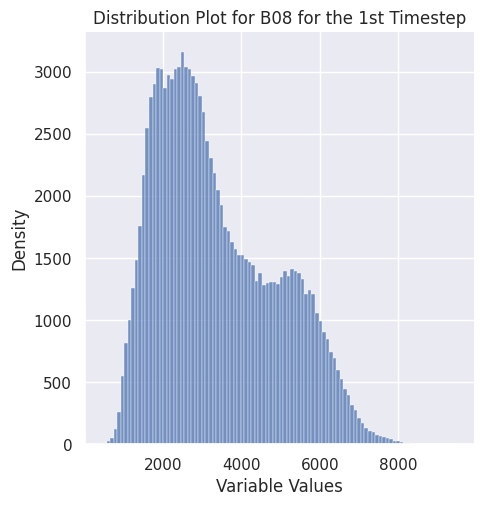

<Figure size 1200x800 with 0 Axes>

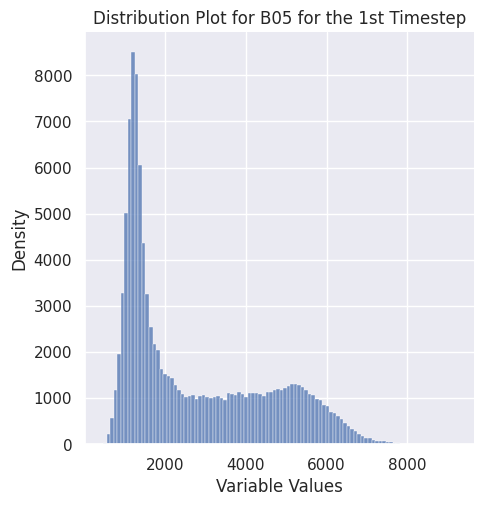

<Figure size 1200x800 with 0 Axes>

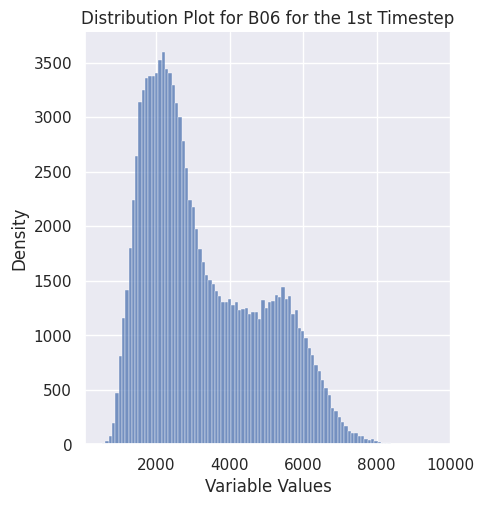

<Figure size 1200x800 with 0 Axes>

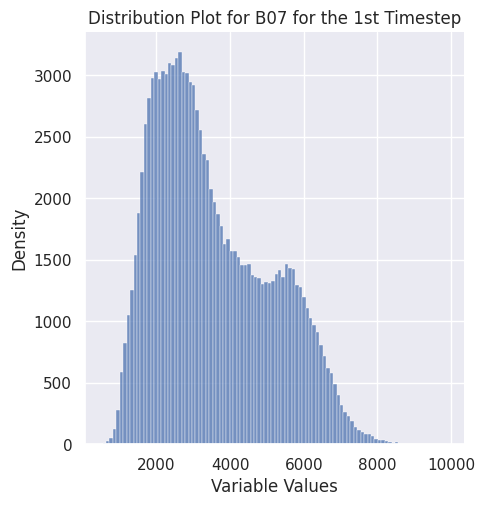

<Figure size 1200x800 with 0 Axes>

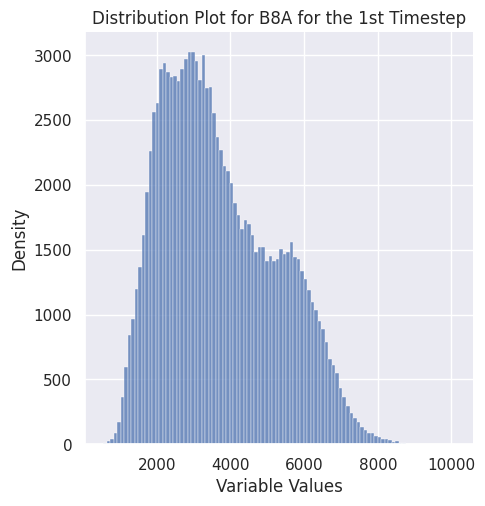

<Figure size 1200x800 with 0 Axes>

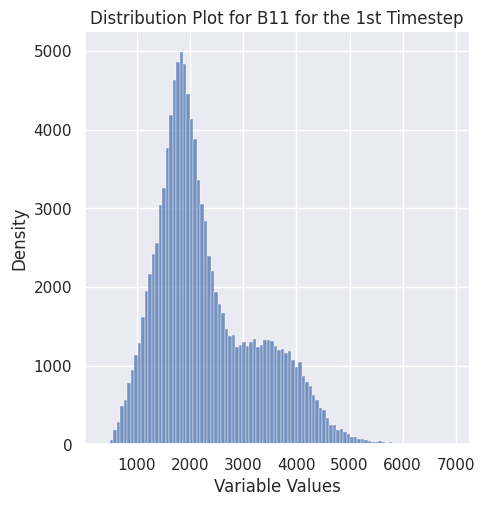

<Figure size 1200x800 with 0 Axes>

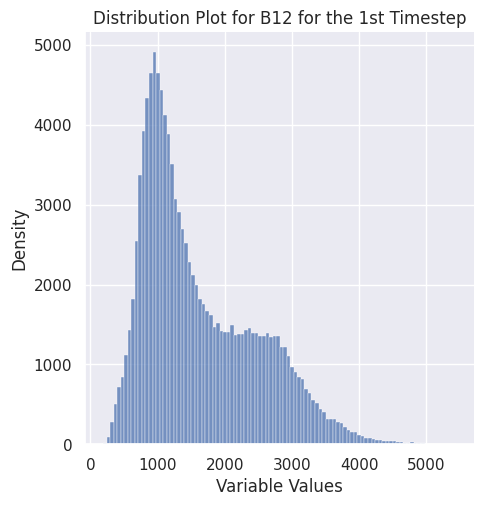

In [ ]:
#Selecting only the first timestep
data_2d_c = series[:, 1, :]
data_2d_c_df = pd.DataFrame(data_2d_c, columns=cols)

sns.set_theme()

warnings.filterwarnings("ignore", category=FutureWarning)

# Plot distribution plots for each variable in separate subplots
for i, column in enumerate(data_2d_c_df.columns):
    plt.figure(figsize=(12, 8))
    sns.displot(data_2d_c_df[column], bins=100)
    plt.title(f'Distribution Plot for {column} for the 1st Timestep')
    plt.xlabel('Variable Values')
    plt.ylabel('Density')

The distribution plot for a single time step shows a different data distribution. However, it is still highly left skewed. Moreover, even when the distribution graphics for all dates show that all bands have a big percentage of 0 values, this is not true for this specific timestep.

The temporal variable  is now analyzed. For this, only with data exploraiton purposes, the "dates" array is converted into a dataframe, to get the descriptive statistics.

In [ ]:
df_time = pd.DataFrame(dates)

In [ ]:
# Showing descriptive statistics
df_time.describe()

,0
count,62
unique,62
top,2017-01-19 00:00:00
freq,1
first,2017-01-19 00:00:00
last,2017-12-28 00:00:00


The descriptive statistics show, mainly, that the observations belong to the year 2017, with the first observation in the month of January and the alst one in the month of December. Aditionally, the barplot below shows the distribution of records per month.

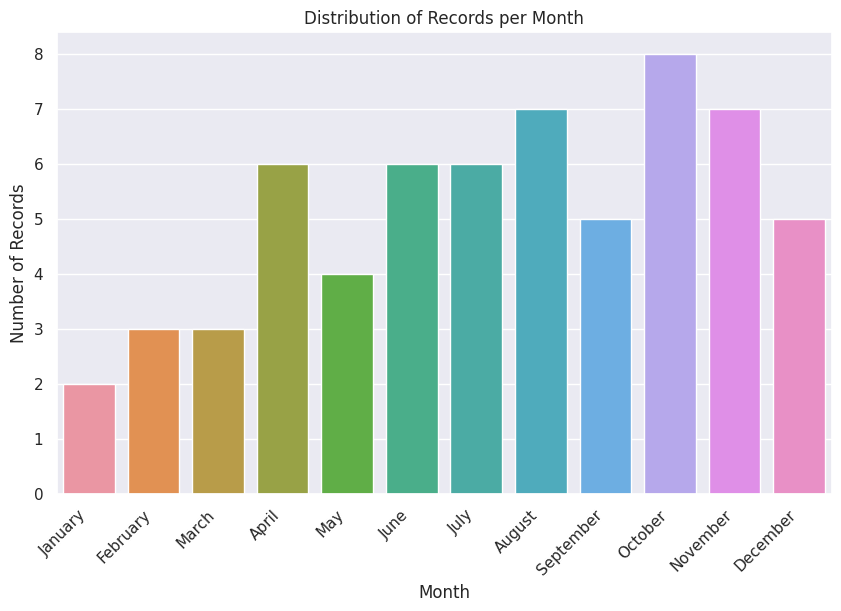

In [ ]:
sns.set_theme()

#Get records per month
df_2 = pd.DataFrame({'count': 1}, index=dates)
monthly_counts = df_2.resample('M').count()

month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Distribution plot
sns.set_theme()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=monthly_counts.index.month, y=monthly_counts['count'], estimator=sum)

plt.xticks(range(0, 12), labels=month_labels, rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('Number of Records')
plt.title('Distribution of Records per Month')
plt.show()

After analyzing the descriptive statistics, together with some exploratory graphics, it is possible to draw some important conclussions about the data characteristics.
Firstly, the records belong to a whole year, from january to december 2017 and the records for each band vary significantly across time. Secondly, the distribution of records across the year is not regular. The number of records is different at every month, and there are more records in the second half of the year than in the first one, which is visible both in the descriptive variables and in the distribution plot.
Finally, the band variables are higly left skewed, with a big presence of 0 values at some specific time steps.

These characteristics allow understanding how to treat the data, implying the need of normalizing the data in a way that every variable has a mean=0 and std=1.

### 2.d. Class Distribution

In this section, the class distribution across the dataset will be analyzed. The importance of this step lies in the fact that, if there is an imbalanced distribution of classes, further steps should be performed at the moment of data splitting.

For this, we will firstly plot a histogram to graphically analyze the classes' distributions

In [ ]:
# Getting labels names
labels_array = np.array(class_names)[labels]


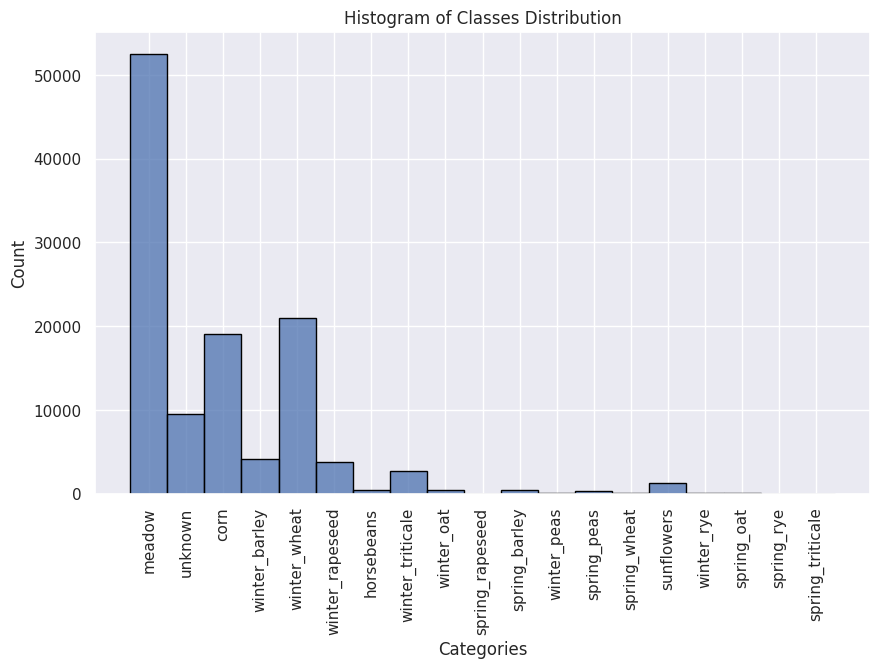

In [ ]:
# Set Seaborn theme
sns.set_theme()

plt.figure(figsize=(10, 6))
sns.histplot(labels_array, bins=len(class_names)-0.5, kde=False, edgecolor='black')

# Add labels names
plt.xticks(range(19), rotation=90)

# Add Titles
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Histogram of Classes Distribution')

# Show the plot
plt.show()

We can clearly observe from the histogram that the classes are highly imbalanced. As, for the scale, some of the classes appear to be non-existent, the number of samples for each class is shown below.

In [11]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

count_dict = dict(zip(class_names, label_counts))

# Sort by total number of samples
count_dict_sort = dict(sorted(count_dict.items(), key=lambda x:x[1], reverse=True))

# Plot number of samples per class
for label, count in count_dict_sort.items():
    print(f'{label}: {count}')

meadow: 52537
winter_wheat: 20990
corn: 19088
unknown: 9510
winter_barley: 4083
winter_rapeseed: 3809
winter_triticale: 2687
sunflowers: 1270
horsebeans: 462
winter_oat: 435
spring_barley: 390
spring_peas: 277
winter_peas: 79
winter_rye: 51
spring_oat: 41
spring_wheat: 32
spring_rapeseed: 10
spring_triticale: 3
spring_rye: 1


One can effectively observe that some of the classes only contain a few samples. The observations belonging to the class `spring_triticale` and `srping_rye`, having only one and three samples resepctively, will be deleted because this presents a big issue for a representative presence of the class after the division of the dataset, making not possible to perform a stratified division into train, test and validation sets. As a remark, `spring_rapseed` class could also potentially present issues, but will be kept for now.

It is important to notice that some other types of data, such as images, easily allow the application of data augmentation techniques that could solve this problem without droping any class. However, for this type of tabular, temporal data, it is much difficult to find right augmentation techniques that effectively address underrepresented classes.

In [12]:
print(class_names)

['corn' 'horsebeans' 'meadow' 'spring_barley' 'spring_oat' 'spring_peas'
 'spring_rapeseed' 'spring_rye' 'spring_triticale' 'spring_wheat'
 'sunflowers' 'unknown' 'winter_barley' 'winter_oat' 'winter_peas'
 'winter_rapeseed' 'winter_rye' 'winter_triticale' 'winter_wheat']


In [13]:
# get index of samples with labels =7 (spring_rye) and labels =8 (spring_triticale)
indices_to_keep = (labels != 7) & (labels != 8)

# Filter dataset, labels and classes
filter_series = series[indices_to_keep]
filter_labels = labels[indices_to_keep]
filter_class_names = ['corn', 'horsebeans', 'meadow', 'spring_barley', 'spring_oat', 'spring_peas',
 'spring_rapeseed', 'spring_wheat', 'sunflowers', 'unknown', 'winter_barley', 'winter_oat',
 'winter_peas', 'winter_rapeseed', 'winter_rye', 'winter_triticale', 'winter_wheat']

In [14]:
np.unique(filter_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
      dtype=int32)

Next, the labels array is remapped to 0-16 index, which is necessary for a correct functioning of the models.

In [15]:
# Mapping dictionary
label_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 9: 7, 10: 8, 11: 9, 12: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16}

# Remap labels using the mapping dictionary
remapped_labels = [label_mapping[label] for label in filter_labels]
remapped_labels = np.array(remapped_labels)


In [16]:
print(np.unique(remapped_labels ))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [17]:
len(np.unique(filter_labels))

17

In [18]:
series.shape

(115755, 62, 10)

In [19]:
filter_series.shape

(115751, 62, 10)

This verifies that the final dataset contains 4 samples less than the original one.

After dealing with the classes' distribution, and noticing that it is higly unbalanced, it is possible to conclude that this is an issue that needs to be considered at the moment of dividing the dataset, in order to have a proportional representation of classes across training, validation and test sets.

## 3. Data preparation

The first step consists on data preparation, in order to define the x and y sets for, later, dividing the data into train, validation and sets.

In [20]:
#Define x and y sets
x = filter_series
y = remapped_labels

#Define classes len (K)
k = len(filter_class_names)
print(k)

17


### 3.1. Data Split

Next, it is necessary to divide the dataset into train, test and validation sets. Doing this before any kind of normalization or processsing ensures that there is no dataleakage happening.

Due to the specific characteristics of the dataset, which were analyzed in detail in the previous sections, it is necessary to perform a split that takes into account the unbalanced classes distribution. This is addressed with a stratified split, that preserves the same samples distribution for each class across the three sub datasets.

Moreover, it is important to remark that it is a generally common adopted practice in timeseries dataset to take the older data observations for training set and the newest for testing. However, in this case, we need to build a model that takes into acocunt the data across all the seasons. As we have data only for one year, taking only the first 70% samples for training would mean that the model is not learning the patterns for the last monts of the year. Because of this, we wont perform a split that takes into account this temporal sequence aspect, and just split it randomly, maintaining the classes distribution. The random split is performed at the first axis of the 3D dataset (the samples), in a way that all the 62 temporal observations of a single pixel always belong to the same set, making sure that the time series are maintained untouched.

The selected proportion to split the data is a commonly used approach of 70% training, 15% validation, 15% test.

In [21]:
# Create a list of the same size as series rows to index
rows = y.shape[0]
indices = list(range(rows))

# Divide the list into train and test, stratifying by labels
# stratify=y divides the dataset keeping a balanced class distribution
# random_state=33 asures reproducibility
train_ind, test_ind = train_test_split(indices, test_size=0.3, stratify=y, random_state=33)

# Index datasets to split
x_train = x[train_ind, :, :]
y_train = y[train_ind]

# Index labels to split
y_test = y[test_ind]

# Divide the test index into train and validation
test_ind, val_ind = train_test_split(test_ind, test_size=0.5, stratify=y_test, random_state=33)

# Index datasets to split
x_test = x[test_ind, :, :]
y_test = y[test_ind]

x_val = x[val_ind, :, :]
y_val = y[val_ind]

print(f' x_train shape: {x_train.shape}')
print(f' x_test shape: {x_test.shape}')
print(f' x_val shape: {x_val.shape}')

print(f' y_train shape: {y_train.shape}')
print(f' y_test shape: {y_test.shape}')
print(f' y_val shape: {y_val.shape}')

 x_train shape: (81025, 62, 10)
 x_test shape: (17363, 62, 10)
 x_val shape: (17363, 62, 10)
 y_train shape: (81025,)
 y_test shape: (17363,)
 y_val shape: (17363,)


### 3.2. Data Normalization
As analyzed in the previous sections, the dataset needs to be normalized in order to ensure that all the variables have the same scale, and a normal distribution. For this, x train, test and validation sets are normalized so that every variable has a mean=0 and std=1. The test and validation sets are normalized using the mean and standard values from the training set, following common data normalization practices that prevent data leakage and allow the future prediciton on new idnependent samples.

In [22]:
# Normalize data
x_train_n = (x_train-np.mean(x_train))/np.std(x_train,ddof=1)
x_val_n = (x_val-np.mean(x_val))/np.std(x_val,ddof=1)
x_test_n = (x_test-np.mean(x_train))/np.std(x_train,ddof=1)

### 3.3. Custom Dataset Class
The next step is to define a custom class for loading the data in batches. The MLP model requires a different input format than the CNN given that MLP needs a faltten input. Because of that, for the first one, the input needs to be reshaped into a vector. To handle this with a single class, a string argument is defined to get the data in the right shape in each case

In [23]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, model_type):
        """
        Args:
            data (numpy.ndarray): Input data of shape [samples, bands, time].
            labels (numpy.ndarray): Vector containing labels for each sample.
            model_type (str): Specifies the used model to shape the data properly ('mlp' or 'cnn').
        """
        self.data = data
        self.labels = labels
        self.model_type = model_type

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        sample = self.data[index]
        label = self.labels[index]

        if self.model_type == 'mlp':
            sample = sample.reshape(-1)
        elif self.model_type == 'cnn':
            pass
        return sample, label


The datasets are converted to tensors

In [24]:
x_train_t = torch.FloatTensor(x_train_n)
y_train_t = torch.LongTensor(y_train)

x_test_t = torch.FloatTensor(x_test_n)
y_test_t = torch.LongTensor(y_test)

x_val_t = torch.FloatTensor(x_val_n)
y_val_t = torch.LongTensor(y_val)

Next, the data is sent to device to be able to access it from GPU.

In [25]:
x_train_t =x_train_t.to(device)
x_val_t =x_val_t.to(device)
x_test_t =x_test_t.to(device)

y_train_t = y_train_t.to(device)
y_val_t = y_val_t.to(device)
y_test_t = y_test_t.to(device)

After that, CustomDataset class is used to create train, test and validation datasets for mlp and cnn models

In [26]:
train_mlp = CustomDataset(x_train_t, y_train_t, model_type='mlp')
val_mlp = CustomDataset(x_val_t, y_val_t, model_type='mlp')
test_mlp = CustomDataset(x_test_t, y_test_t, model_type='mlp')

train_cnn = CustomDataset(x_train_t, y_train_t, model_type='cnn')
val_cnn = CustomDataset(x_val_t, y_val_t, model_type='cnn')
test_cnn = CustomDataset(x_test_t, y_test_t, model_type='cnn')


## 4. Deep learning models

Two models will be implemented for comparing the performance with MiniTimeMatch Dataset. The first one is a vanilla Multi Layer perceptron (MLP) and the second one is an Elman Recurrent Neural Network (RNN)


### 4.1. Multi Layer Perceptron


#### 4.1.a. Data Loading
In order to train the model, the first step is to send the data to the device to use it with GPU and define DataLoader to use minibatch gradient descend.

For this, it is necessary define the batch size, which will be the same across all models in roder to make their performances comparable. For unbalanced classes, as in this case, the bibliography refers that bigger batches give better results. For this exercise, a batch of 32 is selected, as a tradeoff to get a considerable batch size but that is managable with the existent computational resources.

In [27]:
batch_size = 32

In [28]:
n_features = (x.shape[1]*x.shape[2])
print(f'Number of features: {n_features}')
print(f'Number of classes: {k}')


Number of features: 620
Number of classes: 17


In [29]:
# Shuffle=True for training to prevent the model learning the order of samples
train_dataloader_mlp = DataLoader(train_mlp, batch_size=batch_size, shuffle=True)

#Shuffle=False in test and validation so the evaluation is consistent
val_dataloader_mlp = DataLoader(val_mlp, batch_size=batch_size, shuffle=False)
test_dataloader_mlp = DataLoader(test_mlp, batch_size=batch_size, shuffle=False)

#### 4.1.b. Model Definition
The first developed model is a simple Multi Layer Perceptron, with only one hidden layer and 320 hidden units.
There are some discussions in the literature on wether one ore two hidden layers are enough for effectively solving classification problems (Graupe, 2007). In this case, the architecture with one hidden layer is selected considering the most basic possible model to be used as a baseline to compare with other time-series specific architecture.

**Input Units**

The number of input units is equal to the number of features. In this case is 620 which derives from the flattened result of timesteps(62) and variables (10).

**Hidden Layer**

For the definition of the number of hidden units in the hidden layer, there are many rules-of-thumb that consider different aspects such as the input and output layers (Krishnan, 2021). For this case, the number was calculated using the rule that stablish the number of units as the average between the size of the input (features) and the size of the output (classes). As our model has 620 features and 17 classes, the number of hidden units is set to 320

**Relu Activation Function**

The model includes a Relu activation function in the hidden layer to introduce non-linearity to the model, allowing to learn more complex patterns.

**Output Units**

The output units is of the same size as the classes. In this case, 17.


In [30]:
class MLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_units, device=torch.device("cpu")):
        super(MLP, self).__init__()

        # Linear Layers
        self.fcin = nn.Linear(in_size, hidden_units, device=device)
        self.fc1 = nn.Linear(hidden_units, out_size, device=device)

    # Forward pass
    def forward(self, x):
        x = self.fcin(x)
        x = torch.relu(x)
        logits = self.fc1(x)
        return logits
        # There is not softmax layer because CrossEntropyLoss() handles the softmax activation itnernally

In [ ]:
mlp_model = MLP(in_size=n_features, out_size=k, hidden_units= 320, device=device)
print(mlp_model)

MLP(
  (fcin): Linear(in_features=620, out_features=320, bias=True)
  (fc1): Linear(in_features=320, out_features=17, bias=True)
)


#### 4.1.c. Cost Function

After the performed analysis, it is possible to establish the cost function. Considering that the problem is defined as a multiclass classification, Cross-entropy loss is the loss-fucntion better adapted to the case.

In [31]:
def loss_func(z_hat, y):
    return nn.CrossEntropyLoss()(z_hat, y)

#### 4.1.d. Train and Validation Functions

In order to simplify the readability of the code, the training and validation loops for minibatch gradient descent are defined as functions.

In [41]:
# Defining train and validation functions
def train_epoch(model, optimizer, loss_func, dataloader, device):
  model.train()
  train_correct = 0
  train_loss = []
  for x_train_batch, y_train_batch in dataloader:
    # Send data to gpu
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)
    y_hat = model(x_train_batch)
    # Compute loss
    loss = loss_func(y_hat, y_train_batch)
    # Loss gradients
    loss.backward()
    optimizer.step()
    # Reset gradients
    optimizer.zero_grad()
    # Assign labels
    y_hat_class = torch.argmax(y_hat.detach().cpu(), axis=1)
    train_correct += torch.sum(y_hat_class==y_train_batch.cpu())
    train_loss.append(loss.item()/len(x_train_batch))

  train_accuracy = train_correct/len(dataloader.dataset)
  return train_loss, train_accuracy


def val_epoch(model, loss_func, dataloader, device):
  model.eval()
  tmp_val_loss = 0
  val_correct = 0
  with torch.no_grad():
    for x_val_batch, y_val_batch in dataloader:
      x_val_batch = x_val_batch.to(device)
      y_val_batch = y_val_batch.to(device)
      # Forward pass
      y_val_hat = model(x_val_batch)
      tmp_val_loss += loss_func(y_val_hat, y_val_batch).item()
      y_val_hat_class = torch.argmax(y_val_hat.detach().cpu(), axis=1)
      val_correct += torch.sum(y_val_hat_class==y_val_batch.cpu())
  # Compute average loss
  val_loss = tmp_val_loss/len(dataloader.dataset)
  val_accuracy = val_correct/len(dataloader.dataset)

  return val_loss, val_accuracy


#### 4.1.e. Tuning Hyperparameters

Once the model and the training and validation functions are defined, it is necessary to tune the hyperapraemters for the final model. The model is trained using adam optimizer, which computes adaptative learning rates for each parameter independently, combining momentum and RMSprop principles (Kingma, D. P., & Ba, J., 2014).

Adam optimizer requires three main parameters: initial learning rate and B1 and B2. These parameters are the ones that will be tuned using grid search. For this, a logarithmic scale for learning rate is used, following the standard common lr values, (from 0.01 to 0.00001) and two different values for B1 and B2, which follows recommended values in the literature. The hyperaparameters are tunned based on Cross Entropy Loss results, using the validation set, but controling also for accuracy metrics.

Finally, the number of epochs is set to 30, which is a number that allows a significantly number of iterations in training, important when there is pressence of imbalanced class for the model to correctly learn the parameters. A bigger number could be benefitial but, as this step includes hyperparameter tuning, bigger number of epochs are computationally too expensive to implement.

Params: {'betas': (0.9, 0.99), 'lr': 0.01}, Validation Accuracy: 0.8975407481193542, Validation Loss: 0.013274555127420424


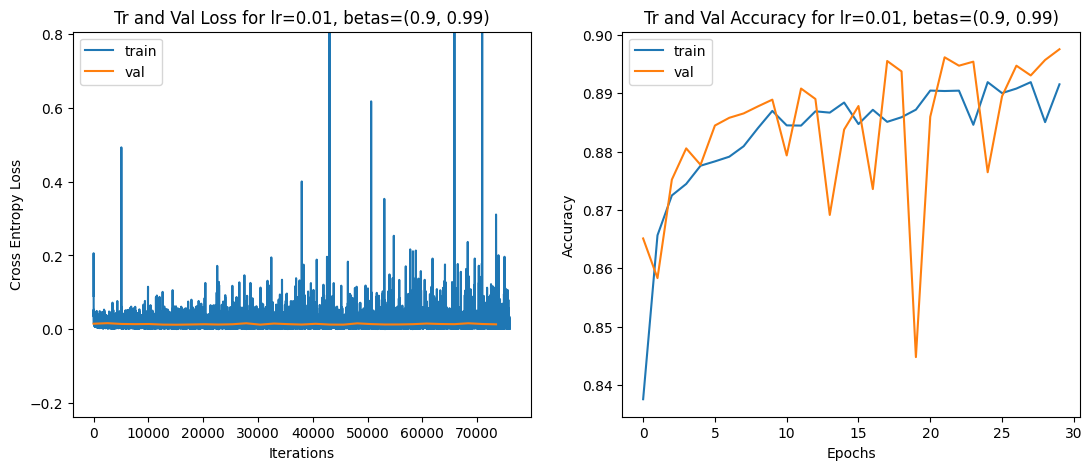

Params: {'betas': (0.9, 0.99), 'lr': 0.001}, Validation Accuracy: 0.9149340391159058, Validation Loss: 0.016308656842285024


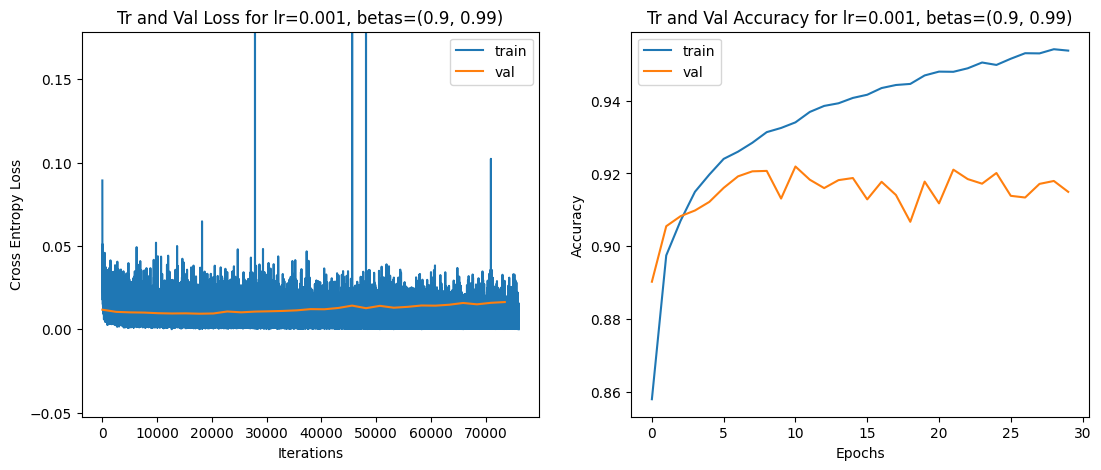

Params: {'betas': (0.9, 0.99), 'lr': 0.0001}, Validation Accuracy: 0.9351494312286377, Validation Loss: 0.007544925924057353


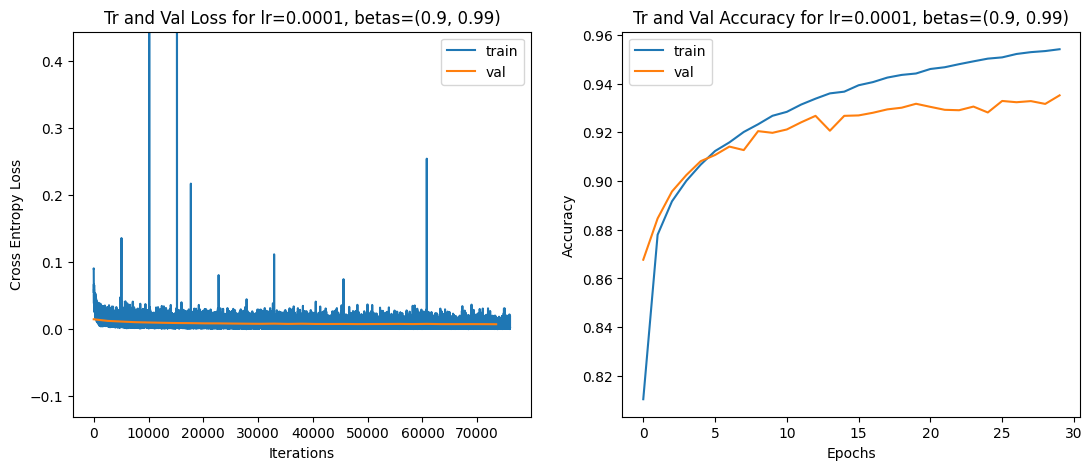

Params: {'betas': (0.9, 0.99), 'lr': 1e-05}, Validation Accuracy: 0.8987502455711365, Validation Loss: 0.011015051078262235


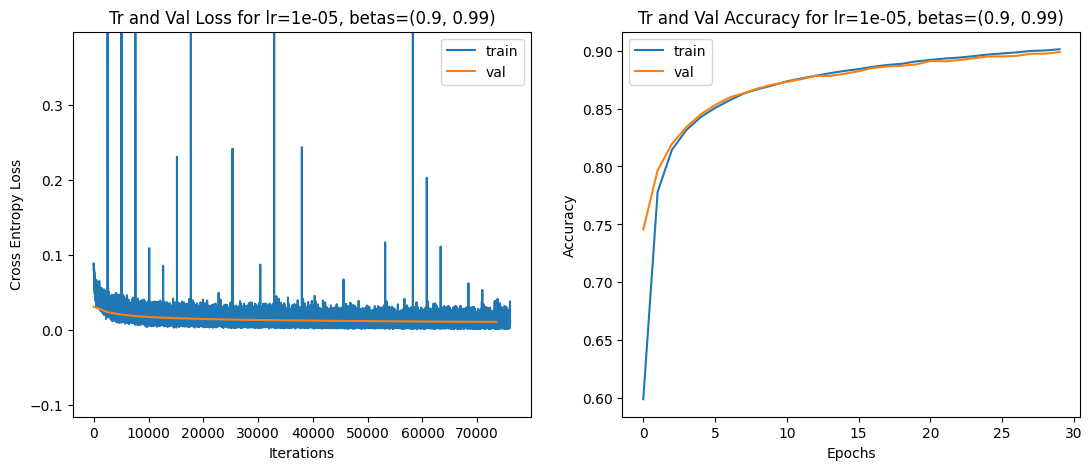

Params: {'betas': (0.95, 0.99), 'lr': 0.01}, Validation Accuracy: 0.8922997117042542, Validation Loss: 0.013259860439095047


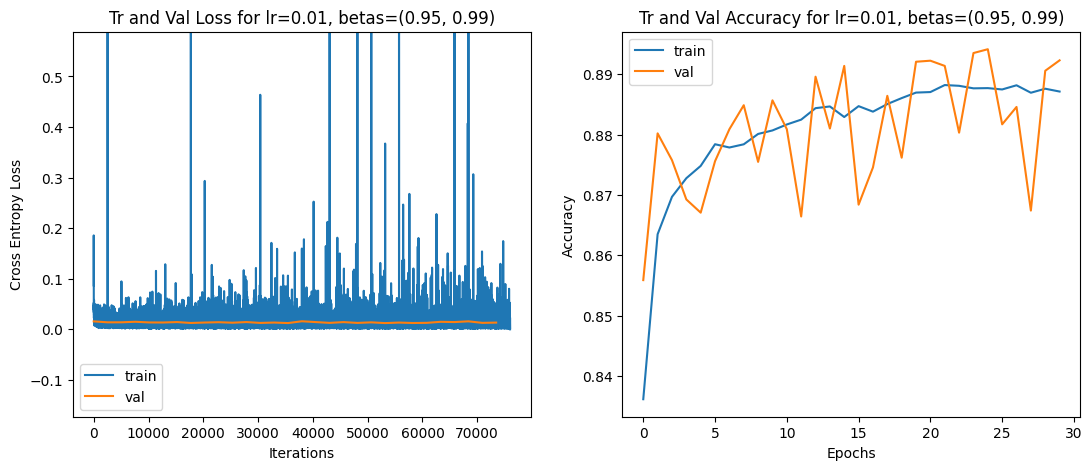

Params: {'betas': (0.95, 0.99), 'lr': 0.001}, Validation Accuracy: 0.9128606915473938, Validation Loss: 0.015511979181364531


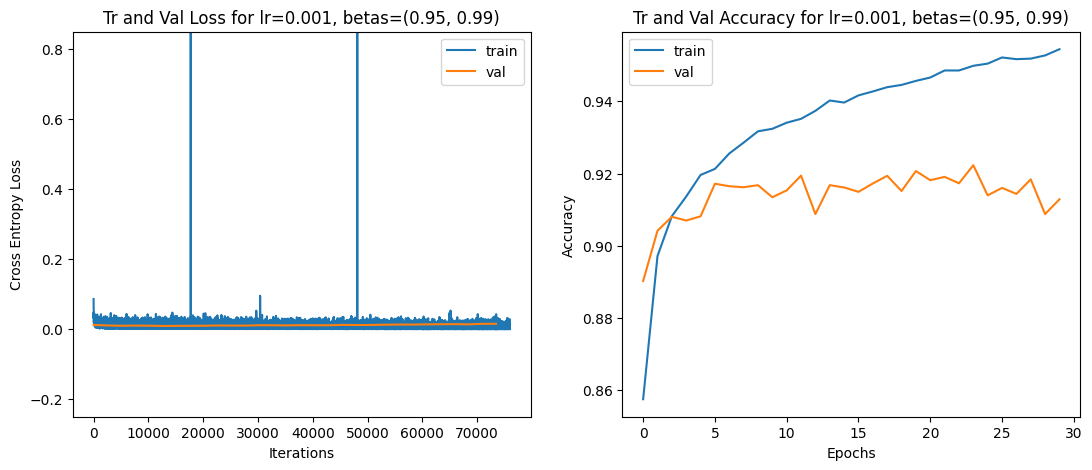

Params: {'betas': (0.95, 0.99), 'lr': 0.0001}, Validation Accuracy: 0.9314058423042297, Validation Loss: 0.007834396083786511


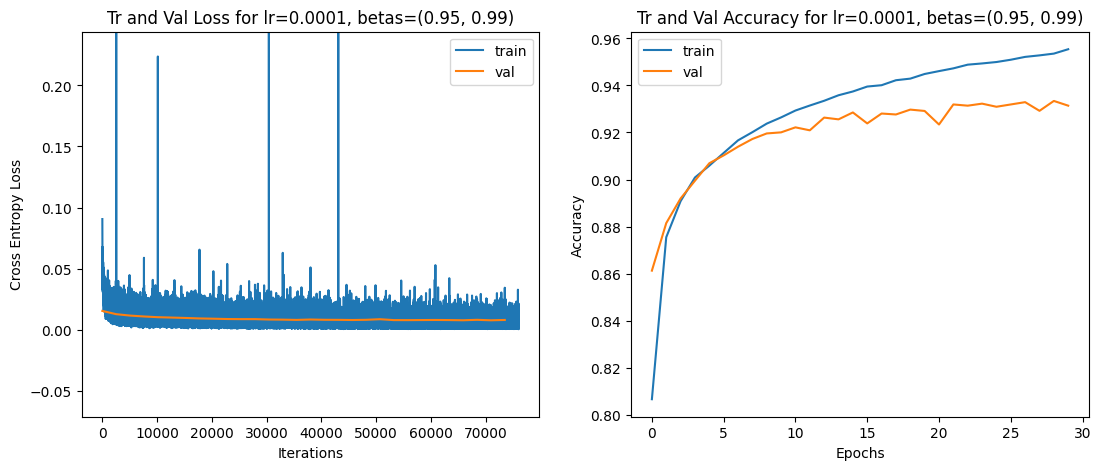

Params: {'betas': (0.95, 0.99), 'lr': 1e-05}, Validation Accuracy: 0.8976559638977051, Validation Loss: 0.011011899387837143


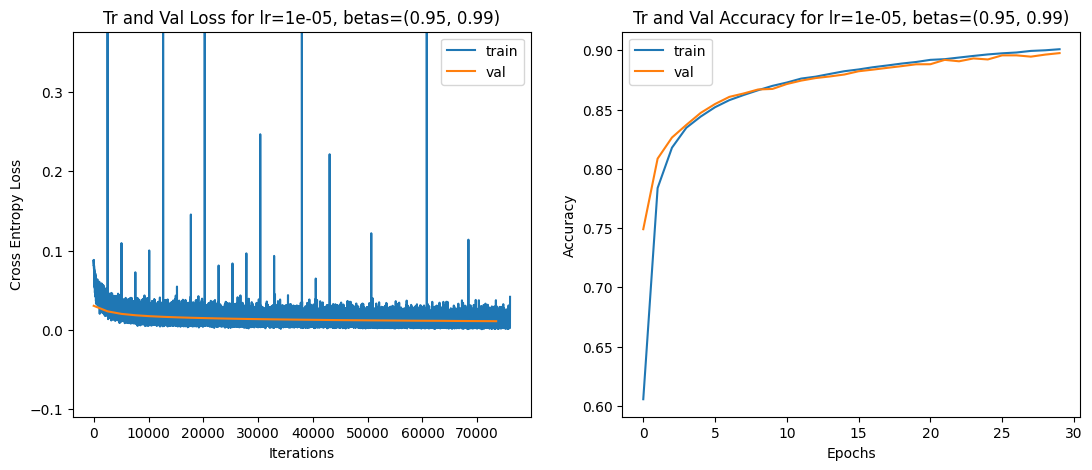

Best Hyperparameters: {'betas': (0.9, 0.99), 'lr': 0.0001}, Best Validation Loss: 0.007544925924057353


In [ ]:
# Define epochs and model
epochs=30

# Hyperparameters for grid search
param_grid = {
    'lr': [0.01, 0.001, 0.0001, 0.00001],
    'betas': [(0.9, 0.99), (0.95, 0.99)]
}

# Create parameter grid
grid = ParameterGrid(param_grid)

# Perform grid search
best_loss = 1.0
best_params = None

for params in grid:
    learning_rate = params['lr']
    betas = params['betas']

    # Define Model
    mlp_model = MLP(in_size=n_features, out_size=k, hidden_units= 320, device=device)
    mlp_model.to(device)

    # Optimizer for each set of hyperparameters
    optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate, betas=betas)

    # Define empty list to store metrics
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []


    # Training loop
    for e in range(epochs):

      # Train and validation with predefined functions
      epoch_train_loss, epoch_train_accuracy = train_epoch(mlp_model, optimizer, loss_func, train_dataloader_mlp, device)
      epoch_val_loss, epoch_val_accuracy = val_epoch(mlp_model, loss_func, val_dataloader_mlp, device)

      # Store metrics
      train_loss.extend(epoch_train_loss)
      train_accuracy.append(epoch_train_accuracy)
      val_loss.append(epoch_val_loss)
      val_accuracy.append(epoch_val_accuracy)

    # Calculate final validation accuracy and loss
    final_val_accuracy = val_accuracy[-1]
    final_val_loss = val_loss[-1]

    # Print validation accuracy for the current hyperparameter set
    print(f'Params: {params}, Validation Accuracy: {final_val_accuracy}, Validation Loss: {final_val_loss}')

    # Plot graphics for each set of parameters
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'Tr and Val Loss for lr={learning_rate}, betas={betas}')
    plt.plot(list(range(epochs*len(train_dataloader_mlp))),train_loss, label="train")
    plt.plot(list(range(0, epochs*len(train_dataloader_mlp),len(train_dataloader_mlp))), val_loss, label="val")
    #Limit y axis to 1/3 in order to see the validation decrease
    y_min, y_max = plt.ylim()
    plt.ylim(y_min, y_min + (y_max - y_min) / 5)
    plt.xlabel('Iterations')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'Tr and Val Accuracy for lr={learning_rate}, betas={betas}')
    plt.plot(list(range(epochs)), train_accuracy, label="train")
    plt.plot(list(range(epochs)),val_accuracy, label="val")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Update best hyperparameters
    if final_val_loss < best_loss:
        best_loss = final_val_loss
        best_params = params
        best_mlp_model = mlp_model

# Save the model with the hyperparameters values that gave the lowest loss
if best_mlp_model is not None:
    torch.save(best_mlp_model, results_path + 'best_mlp_model.pth')

# Print best hyperparameters
print(f'Best Hyperparameters: {best_params}, Best Validation Loss: {best_loss}')

#### 4.1.f. Best MLP Model

The hyperparameter tuning process gives the best hyperparameters values to be used in the final MLP model:

betas: (0.90, 0.99)

lr: 0.0001

The model with these hyperparameters is saved is the mlp_final_model variable.

Two options are defined below for working with this final model:

**Load best model**

The first option, if the optimization loop has been run, is to load the saved model with the best hyperparameters:

In [ ]:
mlp_final_model = torch.load(results_path + 'best_mlp_model.pth')

**Train model with best hyperparameters**

For shortening training times, it is possible to directly train the model with the best hyperparameters:

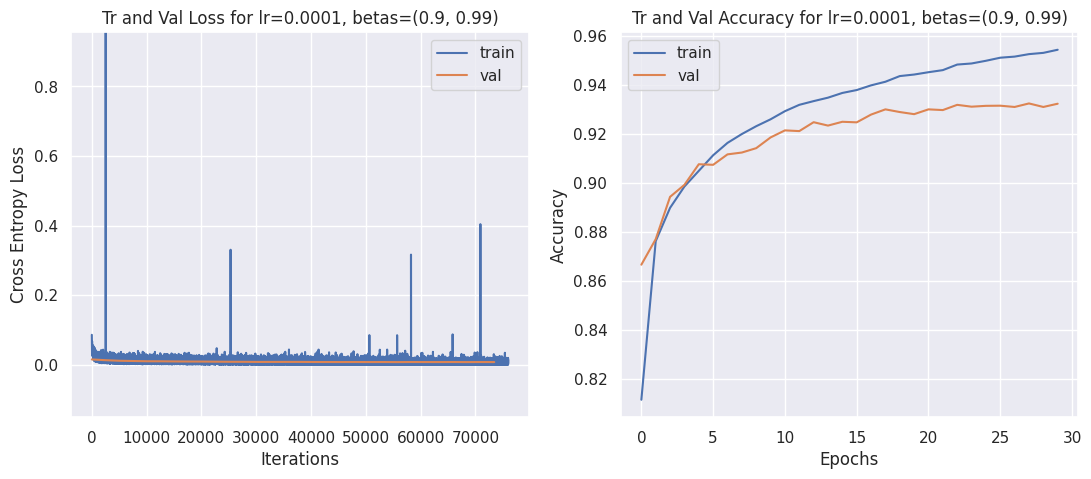

In [ ]:
# Define epochs and model
epochs=30

learning_rate = 0.0001
betas = (0.9, 0.99)

# Define Model
mlp_final_model = MLP(in_size=n_features, out_size=k, hidden_units= 320, device=device)
mlp_final_model.to(device)

# Optimizer for each set of hyperparameters
optimizer = optim.Adam(mlp_final_model.parameters(), lr=learning_rate, betas=betas)

# Define empty list to store metrics
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []


# Training loop
for e in range(epochs):

  # Train and validation with predefined functions
  epoch_train_loss, epoch_train_accuracy = train_epoch(mlp_final_model, optimizer, loss_func, train_dataloader_mlp, device)
  epoch_val_loss, epoch_val_accuracy = val_epoch(mlp_final_model, loss_func, val_dataloader_mlp, device)

  # Store metrics
  train_loss.extend(epoch_train_loss)
  train_accuracy.append(epoch_train_accuracy)
  val_loss.append(epoch_val_loss)
  val_accuracy.append(epoch_val_accuracy)

# Calculate final validation accuracy and loss
final_val_accuracy = val_accuracy[-1]
final_val_loss = val_loss[-1]

torch.save(mlp_final_model, results_path + 'best_mlp_model.pth')

# Plot graphics for each set of parameters
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.title(f'Tr and Val Loss for lr={learning_rate}, betas={betas}')
plt.plot(list(range(epochs*len(train_dataloader_mlp))),train_loss, label="train")
plt.plot(list(range(0, epochs*len(train_dataloader_mlp),len(train_dataloader_mlp))), val_loss, label="val")
#Limit y axis to 1/5 in order to see the validation decrease more clearly
y_min, y_max = plt.ylim()
plt.ylim(y_min, y_min + (y_max - y_min) / 3)
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title(f'Tr and Val Accuracy for lr={learning_rate}, betas={betas}')
plt.plot(list(range(epochs)), train_accuracy, label="train")
plt.plot(list(range(epochs)),val_accuracy, label="val")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 4.2. Elman Recurrent Neural Network

The second implemented model consists on an Elman RNN which can handle the temporal structure of the data. This network, introduced by Jeff Elman in the 1990s, is a type of Multilayer Neural Network augmented with additional context layers. It is characterized by a memory part that stores the output values of previous hidden layers and use them as additional inputs to feed the network (Oeda et al., 2006). Using this structure, the model can learn sequences patterns, being highly suitable for problems such as time-series classification.

#### 4.2.a. Data Loading

The dataloaders are defined, by specifying the string that gives the accurate shape for RNN.

In [38]:
# Shuffle=True for training to prevent the model learning the order of samples
train_dataloader_rnn = DataLoader(train_cnn, batch_size=batch_size, shuffle=True)

#Shuffle=False in test and validation so the evaluation is consistent
val_dataloader_rnn = DataLoader(val_cnn, batch_size=batch_size, shuffle=False)
test_dataloader_rnn = DataLoader(test_cnn, batch_size=batch_size, shuffle=False)

#### 4.2.b. Model Definition

The model is implemented following the architecture of a vanilla RNN, with an input layer, a recurrent layer with hidden state and an output layer. The particularities of the architecture are explained below.

**Recurrent Layers**

In order to evaluate the performance on a similar model than the MLP, just taking into account how the temporal aspect impacts the model, the model is defined with only one recurrent layer.

**Hidden Size**

Following the same logic, the number of hidden units is also kept at 320 to make the model comparable with the MLP.

**Input and Output Size**

The input size corrsponds to the number of input variables, in this case the 10 bands. The number of output layers is the total number of classes (17).

**Activation Function**

Even when the original Elman network is defined with tahn activation function, a ReLU activation function is used in this network, as in the MLP model.This decision is based on the comparability with the MLP model, but also because ReLU has demostrated to present various advantages against Tahn function such as dealing with the vanishing gradient issue.

In [39]:
# Set the dimensions
input_size = 10  # Number of input variables
hidden_size = 320  # Number of features in the hidden state
num_layers = 1  # Number of recurrent layers
output_size = 17  # Number of output classes
sequence_length = 62 # Number of time steps

In [40]:
class Rnn(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(Rnn, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    #Recurrent layer
    # batch_first = True: the first dimension of the input is the batch size
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
    self.fc = nn.Linear(hidden_size*sequence_length, output_size)

  def forward(self, x):
    # x_size(0) defines how many minibatches we send
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    out, _ = self.rnn(x, h0)
    # Keep batch as first axis
    out = out.reshape(out.shape[0], -1)
    # Fully connected layer
    out = self.fc(out)

    return out


In [34]:
rnn_model = Rnn(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
print(rnn_model)

Rnn(
  (rnn): RNN(10, 320, batch_first=True)
  (fc): Linear(in_features=19840, out_features=17, bias=True)
)


#### 4.2.c. Tuning Hyperparameters

For the RNN model, the hyperparameters are tunned following the same procedure as in the MLP.

Params: {'betas': (0.9, 0.99), 'lr': 0.01}, Validation Accuracy: 0.923342764377594, Validation Loss: 0.009679778304339581


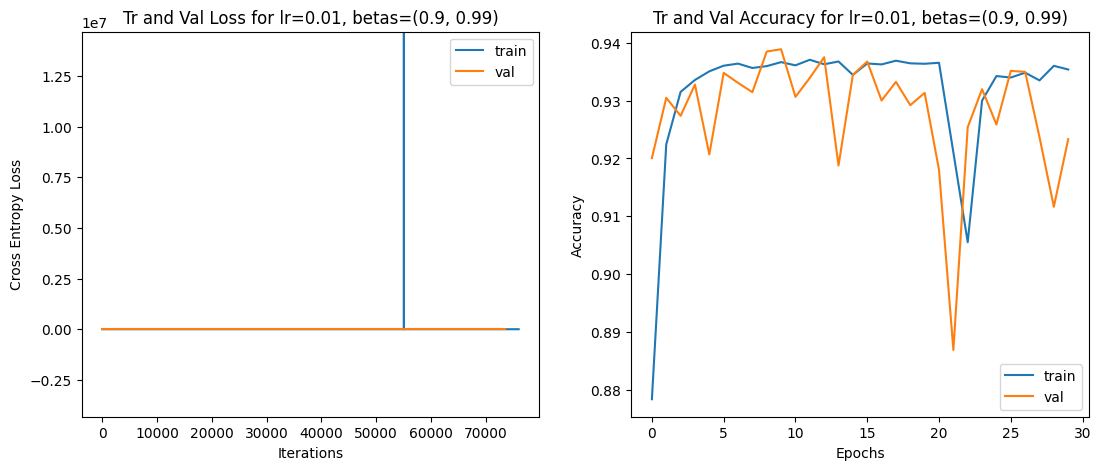

Params: {'betas': (0.9, 0.99), 'lr': 0.001}, Validation Accuracy: 0.9394689798355103, Validation Loss: 0.009132604227794324


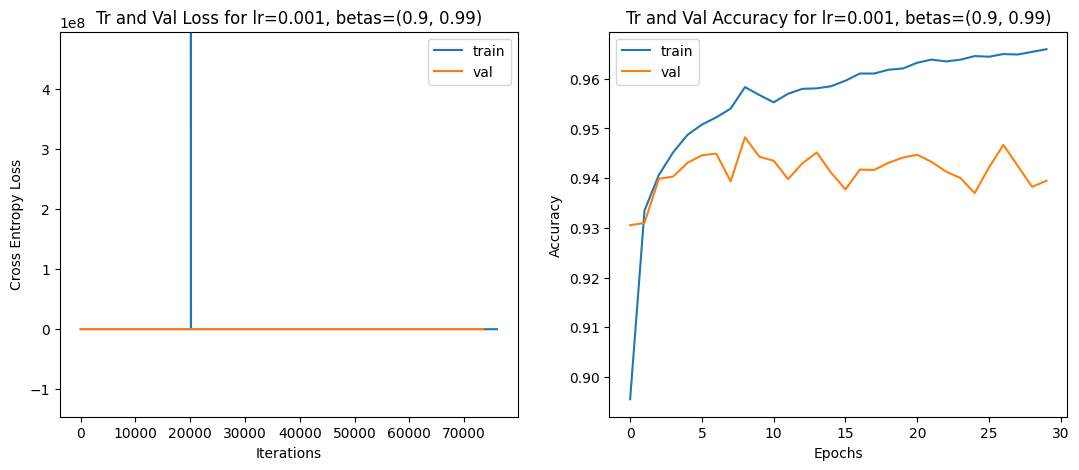

Params: {'betas': (0.9, 0.99), 'lr': 0.0001}, Validation Accuracy: 0.9477624893188477, Validation Loss: 0.0065561259723084095


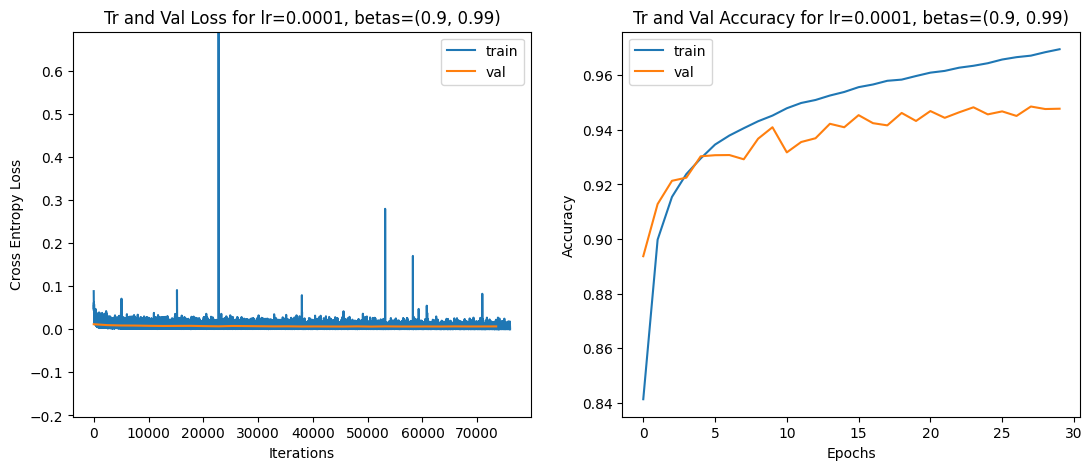

Params: {'betas': (0.95, 0.99), 'lr': 0.01}, Validation Accuracy: 0.9054886698722839, Validation Loss: 0.011570801744210187


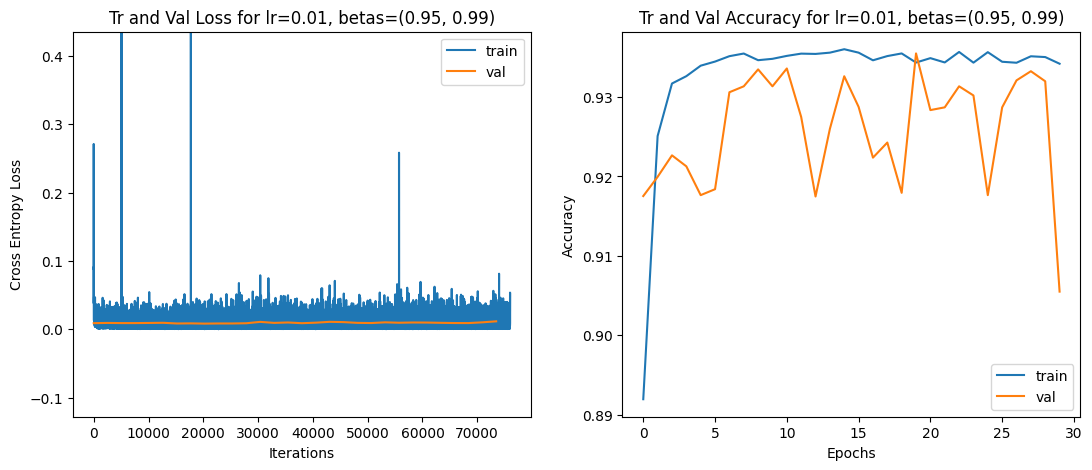

Params: {'betas': (0.95, 0.99), 'lr': 0.001}, Validation Accuracy: 0.9413120150566101, Validation Loss: 0.011029285230752537


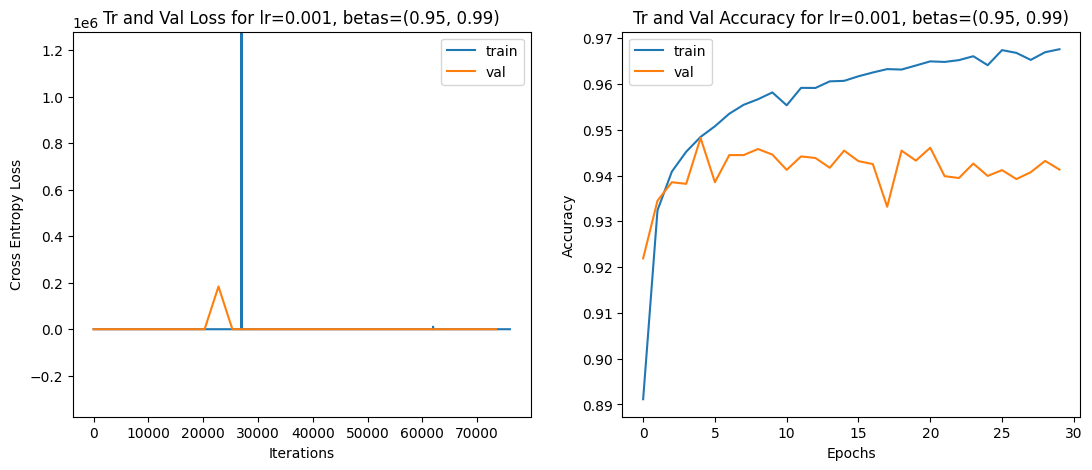

Params: {'betas': (0.95, 0.99), 'lr': 0.0001}, Validation Accuracy: 0.9489143490791321, Validation Loss: 0.006490037946965628


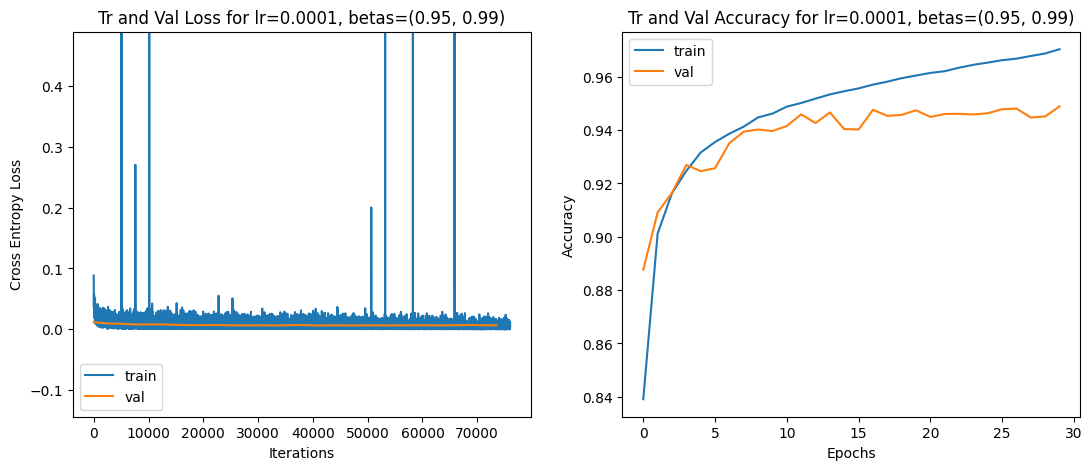

Best Hyperparameters: {'betas': (0.95, 0.99), 'lr': 0.0001}, Best Validation Loss: 0.006490037946965628


In [42]:
# Define epochs and model
epochs=30

# Hyperparameters for grid search
param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'betas': [(0.9, 0.99), (0.95, 0.99)]
}

# Create parameter grid
grid = ParameterGrid(param_grid)

# Perform grid search
best_loss = 1.0
best_params = None

for params in grid:
    learning_rate = params['lr']
    betas = params['betas']

    # Define Model
    rnn_model = Rnn(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
    rnn_model.to(device)

    # Optimizer for each set of hyperparameters
    optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate, betas=betas)

    # Define empty list to store metrics
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []


    # Training loop
    for e in range(epochs):

      # Train and validation with predefined functions
      epoch_train_loss, epoch_train_accuracy = train_epoch(rnn_model, optimizer, loss_func, train_dataloader_rnn, device)
      epoch_val_loss, epoch_val_accuracy = val_epoch(rnn_model, loss_func, val_dataloader_rnn, device)

      # Store metrics
      train_loss.extend(epoch_train_loss)
      train_accuracy.append(epoch_train_accuracy)
      val_loss.append(epoch_val_loss)
      val_accuracy.append(epoch_val_accuracy)

    # Calculate final validation accuracy and loss
    final_val_accuracy = val_accuracy[-1]
    final_val_loss = val_loss[-1]

    # Print validation accuracy for the current hyperparameter set
    print(f'Params: {params}, Validation Accuracy: {final_val_accuracy}, Validation Loss: {final_val_loss}')

    # Plot graphics for each set of parameters
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'Tr and Val Loss for lr={learning_rate}, betas={betas}')
    plt.plot(list(range(epochs*len(train_dataloader_rnn))),train_loss, label="train")
    plt.plot(list(range(0, epochs*len(train_dataloader_rnn),len(train_dataloader_rnn))), val_loss, label="val")
    #Limit y axis to 1/5 in order to see the validation decrease more clearly
    y_min, y_max = plt.ylim()
    plt.ylim(y_min, y_min + (y_max - y_min) / 5)
    plt.xlabel('Iterations')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'Tr and Val Accuracy for lr={learning_rate}, betas={betas}')
    plt.plot(list(range(epochs)), train_accuracy, label="train")
    plt.plot(list(range(epochs)),val_accuracy, label="val")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Update best hyperparameters
    if final_val_loss < best_loss:
        best_loss = final_val_loss
        best_params = params
        best_rnn_model = rnn_model

# Save the model with the hyperparameters values that gave the lowest loss
if best_rnn_model is not None:
    torch.save(best_rnn_model, results_path + 'best_rnn_model_relu.pth')

# Print best hyperparameters
print(f'Best Hyperparameters: {best_params}, Best Validation Loss: {best_loss}')

#### 4.1.f. Best RNN Model

The hyperparameter tuning process gives the best hyperparameters values to be used in the final RNN model:

betas: (0.95, 0.99)

lr: 0.0001

The model with these hyperparameters is saved is the rnn_final_model variable.

As in the MLP case, the two options for loading the best model or training a new model with the selected hyperparameters are proposed below:

**Load best model**

In [ ]:
rnn_final_model = torch.load(results_path + 'best_rnn_model_relu.pth')

**Train model with best hyperparameters**



Params: {'betas': (0.95, 0.99), 'lr': 0.0001}, Validation Accuracy: 0.9481080174446106, Validation Loss: 0.00648318154432473


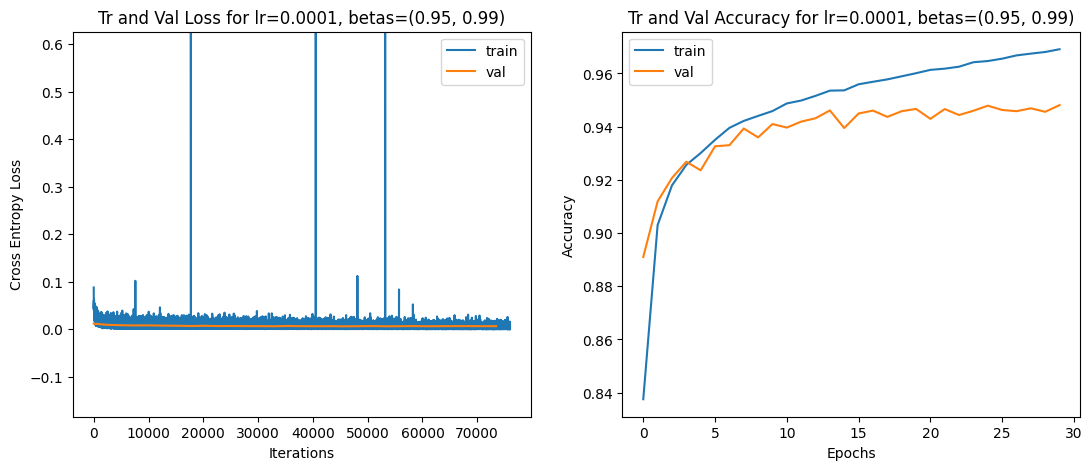

In [44]:
# Define epochs and model
epochs=30

learning_rate = 0.0001
betas = (0.95, 0.99)

# Define Model
rnn_final_model = Rnn(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
rnn_final_model.to(device)

# Optimizer for each set of hyperparameters
optimizer = optim.Adam(rnn_final_model.parameters(), lr=learning_rate, betas=betas)

# Define empty list to store metrics
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Training loop
for e in range(epochs):

  # Train and validation with predefined functions
  epoch_train_loss, epoch_train_accuracy = train_epoch(rnn_final_model, optimizer, loss_func, train_dataloader_rnn, device)
  epoch_val_loss, epoch_val_accuracy = val_epoch(rnn_final_model, loss_func, val_dataloader_rnn, device)

  # Store metrics
  train_loss.extend(epoch_train_loss)
  train_accuracy.append(epoch_train_accuracy)
  val_loss.append(epoch_val_loss)
  val_accuracy.append(epoch_val_accuracy)

# Calculate final validation accuracy and loss
final_val_accuracy = val_accuracy[-1]
final_val_loss = val_loss[-1]

# Print validation accuracy for the current hyperparameter set
print(f'Params: {params}, Validation Accuracy: {final_val_accuracy}, Validation Loss: {final_val_loss}')

#Save model
torch.save(rnn_final_model, results_path + 'best_rnn_model_relu.pth')

# Plot graphics for each set of parameters
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.title(f'Tr and Val Loss for lr={learning_rate}, betas={betas}')
plt.plot(list(range(epochs*len(train_dataloader_rnn))),train_loss, label="train")
plt.plot(list(range(0, epochs*len(train_dataloader_rnn),len(train_dataloader_rnn))), val_loss, label="val")
#Limit y axis to 1/5 in order to see the validation decrease more clearly
y_min, y_max = plt.ylim()
plt.ylim(y_min, y_min + (y_max - y_min) / 5)
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title(f'Tr and Val Accuracy for lr={learning_rate}, betas={betas}')
plt.plot(list(range(epochs)), train_accuracy, label="train")
plt.plot(list(range(epochs)),val_accuracy, label="val")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 5. Performance
To evaluate the performance, both models are tested on the test dataset, which was defined at the beginning of the project and never used during the training. Moreover, the number of parameters of each model is also computed to analyze the trade off between accuracy and complexity.

In order to assure a fair comparison, both models were trained using the same batch size and number of epochs. Moreover, the number of hidden layers and hidden unit was kept the same, to have a clearer visualization of the impact of the temporal aspect in the model capacity.

For a better code readability, a test function is defined. Morevoer, a second function count_parameters() is also defined, which returns the total number of trainable parameters at each model. Also the confussion matrix is plotted.

In [45]:
def test_model(model, criterion, dataloader, device=device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track loss and accuracy
    running_loss = 0.0
    running_corrects = 0

    # Disable gradient computation during testing
    with torch.no_grad():
        # Iterate through the test dataset
        for inputs, labels in dataloader:
            # Move inputs and labels to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass to get predictions
            outputs = model(inputs)

            # Calculate loss
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Update running loss and correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    # Calculate total loss and accuracy over the entire dataset
    total_loss = running_loss / len(dataloader.dataset)
    accuracy = running_corrects.double() / len(dataloader.dataset)

    # Print test loss and accuracy
    print(f'Test Loss: {total_loss:.3f} Acc: {accuracy:.3f}')

    # Return total loss and accuracy
    return total_loss, accuracy

In [46]:
def count_parameters(model):
    # Count the number of parameters in the model that require gradients
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Print the total number of optimized parameters
    print(f'Number of optimized parameters: {num_params}')

In [47]:
def plot_confusion_matrix(model, dataloader, class_labels, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels, vmin=np.min(cm), vmax=np.max(cm), norm=LogNorm(vmin=0.1, vmax=None, clip=True))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

     # Display classification report
    print("Classification Report:\n", classification_report(all_labels, all_preds))



### 5.a. Test MLP Model

The MLP Model is tested first, getting its number of optimized parameters.

In [ ]:
test_model(mlp_final_model, loss_func, test_dataloader_mlp, device = device)

Test Loss: 0.234 Acc: 0.938


(0.2336021536993488, tensor(0.9375, device='cuda:0', dtype=torch.float64))

In [ ]:
count_parameters(mlp_final_model)

Number of optimized parameters: 204177


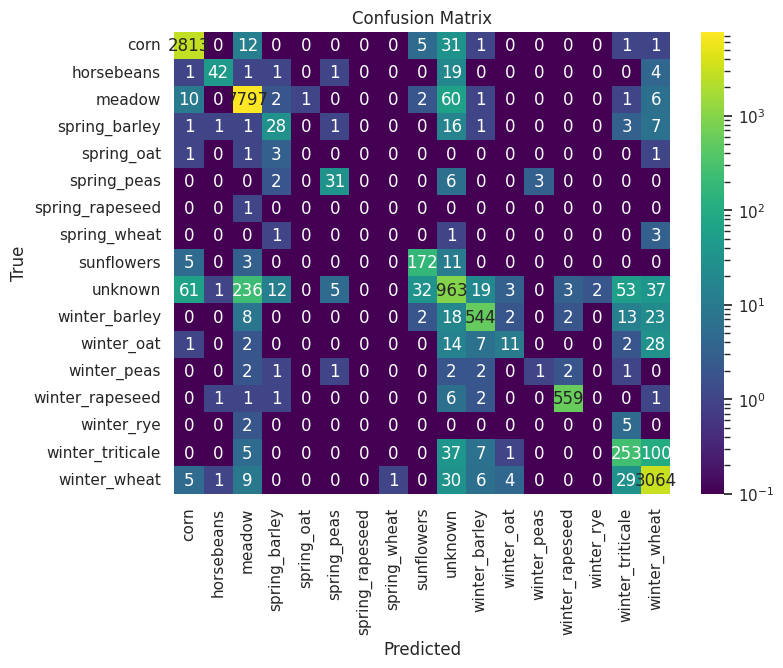

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      2864
           1       0.91      0.61      0.73        69
           2       0.96      0.99      0.98      7880
           3       0.55      0.47      0.51        59
           4       0.00      0.00      0.00         6
           5       0.79      0.74      0.77        42
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       0.81      0.90      0.85       191
           9       0.79      0.67      0.73      1427
          10       0.92      0.89      0.91       612
          11       0.52      0.17      0.26        65
          12       0.25      0.08      0.12        12
          13       0.99      0.98      0.98       571
          14       0.00      0.00      0.00         7
          15       0.70      0.63      0.66       403
          16       0.94      0.97      0.95      3149

  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_confusion_matrix(mlp_final_model, test_dataloader_mlp, filter_class_names)

### 5.b. Test RNN Model

After, the RNN Model is also tested following the same procedure.

In [48]:
test_model(rnn_final_model, loss_func, test_dataloader_rnn, device = device)

Test Loss: 0.198 Acc: 0.951


(0.1979291106529771, tensor(0.9505, device='cuda:0', dtype=torch.float64))

In [49]:
count_parameters(rnn_final_model)

Number of optimized parameters: 443537


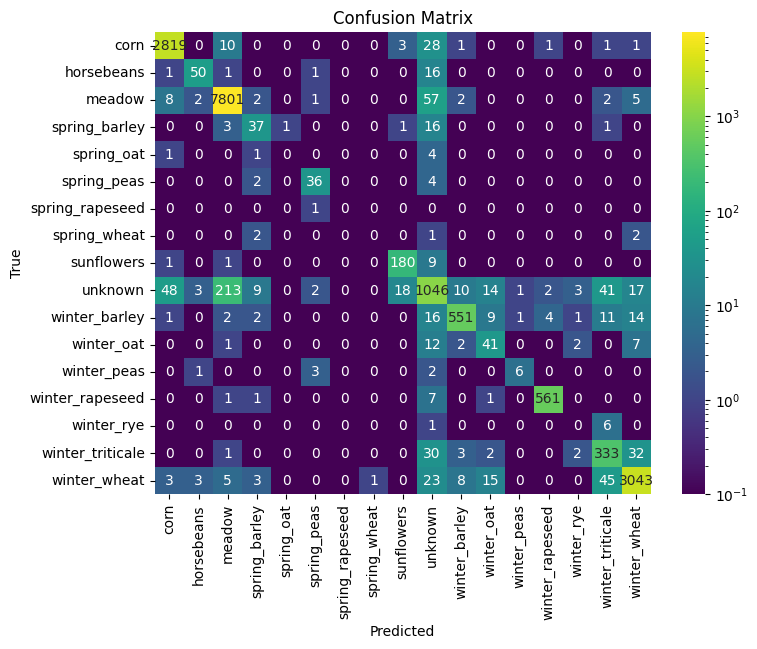

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2864
           1       0.85      0.72      0.78        69
           2       0.97      0.99      0.98      7880
           3       0.63      0.63      0.63        59
           4       0.00      0.00      0.00         6
           5       0.82      0.86      0.84        42
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       0.89      0.94      0.92       191
           9       0.82      0.73      0.78      1427
          10       0.95      0.90      0.93       612
          11       0.50      0.63      0.56        65
          12       0.75      0.50      0.60        12
          13       0.99      0.98      0.99       571
          14       0.00      0.00      0.00         7
          15       0.76      0.83      0.79       403
          16       0.98      0.97      0.97      3149

  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
plot_confusion_matrix(rnn_final_model, test_dataloader_rnn, filter_class_names)

## 6. Conclussions

After getting the results for both models, a summary of these values is shown below:

| Model | Accuracy | Loss | N° of Parameters |
|-------|----------|------|------------------|
| MLP   | 0.936       | 0.236    | 204177    |
| RNN   | 0.951       | 0.199    | 443537    |

The results show a really low difference in the accuracy and loss for both models, but with a strong difference in the number of trainable parameters, which also affets the training time.

If we analyze the trade-off between the complexity and the accuracy results, where the RNN model has more than twice the parameters of MLP, we can conclude that the vanilla MLP has a much better performance than the RNN.  In this sense it is interesting to notice how the addition of the time variable, though the recurrent layer, had almost no impact on the accuracy of the model. At the same time, it is interesting to see that the vanilla MLP, with only one layer, was able to obtain a really good accuracy value of 0.93. In this sense, if it was needed to choose a model for this dataset, it is possible to conclude that the simple MLP would be the best one.

When analyzing more in detail the accurate and wrong classifications class per class, through the confussion matrix, and the  classification report, there are some interesting elements to point out. Firstly, it is important to notice how the imbalance of classes has a big impact on the accuracy.In this sense, the classes with a bigger number of samples in the original datset, such as `corn`, `meadow`and `winter_wheat`show a much better performance than those with a small amount of samples. Moreover, there are three classes with a low number of samples in the original dataset (`winter_rye`, `spring_oat`, `spring_wheat`and `spring_rapseed`) achieve a zero accuracy score on both models.

These characteristics allow concluding that the inbalanced classes is one of the main issues with the Mini TimeMatch Dataset, and that a greater amount of samples for the minor classes would allow achieving a much better glocal performance. In this sense, for future work, it eould be interesting working on possible data augmentation techniques (such as those creating artificial data from real samples distribution), in order to see if this would have a benefitial impact on the models.


## 7. References

Brownlee, J. (2018). LSTM for Time Series Prediction in PyTorch. Machine Learning Mastery. Retrieved from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

Graupe, D. (2007). Principles of Artifical Neural Networks. World Scientific Publishing.

Hochreiter, S., & Schmidhuber, J. (2015). Long Short-Term Memory. arXiv preprint arXiv:1412.6980. Retrieved from https://arxiv.org/abs/1412.6980

Nyborg, J., Pelletier, C., Lef`evre, S., & Assent, I. (2022). TimeMatch: Unsupervised cross-region adaptation by temporal shift estimation. ISPRS Journal of Photogrammetry and Remote Sensing, 188, 301-313.

Painblanc, F., Chapel, L., Courty, N., Friguet, C., Pelletier, C., & Tavenard, R. (2023, September). Match-And-Deform: Time Series Domain Adaptation through Optimal Transport and Temporal Alignment. In Joint European Conference on Machine Learning and Knowledge Discovery in Databases (pp. 341-356).Cham:Springer Nature Switzerland.

Patel, M. (2021). Introduction to Neural Network. Geek Culture. Retrieved from https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3

PyTorch Documentation. (n.d.). torch.nn.RNN. Retrieved from https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

Rascovsky, D. (n.d.). Scikit-Learn Time Series Split. Retrieved from https://www.rasgoml.com/feature-engineering-tutorials/scikit-learn-time-series-split

Stack Overflow. (2021). How to a split time series data for scikit-learn classification correctly. Retrieved from https://stackoverflow.com/questions/70099046/how-to-a-split-time-series-data-for-sklearn-classification-correctly

Sentdex. (2016). Machine Learning for Trading - Creating a Neural Network in Python. YouTube. Retrieved from https://www.youtube.com/watch?v=Gl2WXLIMvKA





